In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""
test=""
z_diff=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "uber"
z_range = "all_z"
key = ""
quantile = ""
test = "background"
z_diff = 0.02


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
z_diff=float(z_diff)

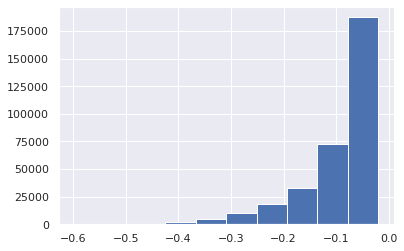

In [5]:
if test=="foreground":
    members=shapes[(shapes[('All','Z')]-shapes[('All','ZRED2')])>=z_diff]
    diff=members[('All','Z')]-members[('All','ZRED2')]
    diff.hist()
    diff.describe()
    
elif test=="background":
    members=background=shapes[(shapes[('All','Z')]-shapes[('All','ZRED2')])<=-z_diff]
    diff=members[('All','Z')]-members[('All','ZRED2')]
    diff.hist()
    diff.describe()
elif test=="":
    members=shapes
else:
    raise TypeError

In [6]:
if vol!="uber":
    members=shapes

In [7]:
if quantile!="":
    i=int(quantile)

In [8]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [9]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [10]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [11]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [12]:
NBINS=10

In [13]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [14]:
len(shapes)

1079244

In [15]:
len(members)

329287

In [16]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [17]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=members[members['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [18]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [19]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [20]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

3it [00:00, 27.04it/s]

11it [00:00, 33.20it/s]

18it [00:00, 38.73it/s]

24it [00:00, 42.54it/s]

32it [00:00, 48.36it/s]

40it [00:00, 53.63it/s]

48it [00:00, 57.88it/s]

56it [00:00, 61.83it/s]

64it [00:01, 64.20it/s]

72it [00:01, 66.03it/s]

80it [00:01, 67.34it/s]

87it [00:01, 64.72it/s]

95it [00:01, 66.64it/s]

103it [00:01, 68.16it/s]

111it [00:01, 69.26it/s]

119it [00:01, 69.79it/s]

127it [00:01, 70.27it/s]

135it [00:02, 70.61it/s]

143it [00:02, 67.40it/s]

150it [00:02, 67.82it/s]

158it [00:02, 69.48it/s]

166it [00:02, 70.38it/s]

174it [00:02, 67.15it/s]

181it [00:02, 64.10it/s]

188it [00:02, 62.16it/s]

195it [00:02, 63.03it/s]

202it [00:03, 62.24it/s]

209it [00:03, 64.37it/s]

216it [00:03, 62.81it/s]

224it [00:03, 65.18it/s]

232it [00:03, 66.95it/s]

240it [00:03, 68.59it/s]

247it [00:03, 68.98it/s]

255it [00:03, 69.88it/s]

263it [00:03, 68.34it/s]

270it [00:04, 66.10it/s]

277it [00:04, 63.63it/s]

285it [00:04, 65.72it/s]

292it [00:04, 62.09it/s]

299it [00:04, 60.96it/s]

306it [00:04, 62.18it/s]

313it [00:04, 63.16it/s]

320it [00:04, 61.48it/s]

328it [00:04, 64.04it/s]

336it [00:05, 65.93it/s]

343it [00:05, 65.32it/s]

350it [00:05, 62.20it/s]

357it [00:05, 61.47it/s]

364it [00:05, 63.10it/s]

372it [00:05, 65.21it/s]

379it [00:05, 62.28it/s]

386it [00:05, 62.82it/s]

394it [00:06, 65.09it/s]

402it [00:06, 66.64it/s]

409it [00:06, 67.39it/s]

417it [00:06, 68.45it/s]

424it [00:06, 67.42it/s]

431it [00:06, 66.06it/s]

438it [00:06, 66.07it/s]

446it [00:06, 67.31it/s]

453it [00:06, 59.02it/s]

460it [00:07, 59.07it/s]

467it [00:07, 57.72it/s]

473it [00:07, 57.56it/s]

479it [00:07, 56.95it/s]

485it [00:07, 54.23it/s]

492it [00:07, 58.03it/s]

498it [00:07, 55.93it/s]

506it [00:07, 59.88it/s]

514it [00:07, 62.75it/s]

521it [00:08, 59.73it/s]

528it [00:08, 58.97it/s]

534it [00:08, 56.67it/s]

541it [00:08, 60.08it/s]

549it [00:08, 62.78it/s]

556it [00:08, 60.72it/s]

563it [00:08, 57.06it/s]

569it [00:08, 56.17it/s]

576it [00:09, 57.50it/s]

584it [00:09, 60.84it/s]

592it [00:09, 63.53it/s]

599it [00:09, 65.14it/s]

607it [00:09, 66.63it/s]

615it [00:09, 67.55it/s]

623it [00:09, 68.40it/s]

630it [00:09, 68.78it/s]

638it [00:09, 69.39it/s]

645it [00:10, 67.88it/s]

652it [00:10, 61.55it/s]

659it [00:10, 60.39it/s]

666it [00:10, 62.48it/s]

673it [00:10, 63.87it/s]

680it [00:10, 65.46it/s]

687it [00:10, 66.05it/s]

695it [00:10, 67.11it/s]

702it [00:10, 67.95it/s]

709it [00:11, 68.13it/s]

717it [00:11, 68.81it/s]

725it [00:11, 69.56it/s]

733it [00:11, 70.09it/s]

741it [00:11, 70.53it/s]

749it [00:11, 70.73it/s]

757it [00:11, 69.85it/s]

764it [00:11, 68.49it/s]

771it [00:11, 68.56it/s]

778it [00:12, 68.76it/s]

786it [00:12, 69.05it/s]

793it [00:12, 67.61it/s]

801it [00:12, 68.17it/s]

808it [00:12, 66.40it/s]

815it [00:12, 67.00it/s]

822it [00:12, 67.49it/s]

829it [00:12, 67.66it/s]

836it [00:12, 67.96it/s]

843it [00:12, 67.89it/s]

850it [00:13, 67.97it/s]

857it [00:13, 65.92it/s]

865it [00:13, 67.27it/s]

873it [00:13, 68.47it/s]

880it [00:13, 68.69it/s]

887it [00:13, 63.25it/s]

894it [00:13, 55.14it/s]

901it [00:13, 57.66it/s]

908it [00:14, 59.64it/s]

915it [00:14, 54.85it/s]

921it [00:14, 55.18it/s]

927it [00:14, 55.28it/s]

933it [00:14, 55.54it/s]

939it [00:14, 56.01it/s]

945it [00:14, 56.06it/s]

951it [00:14, 54.32it/s]

959it [00:14, 58.66it/s]

967it [00:15, 61.80it/s]

975it [00:15, 64.28it/s]

982it [00:15, 65.68it/s]

990it [00:15, 66.84it/s]

997it [00:15, 67.67it/s]

1005it [00:15, 68.67it/s]

1013it [00:15, 69.19it/s]

1020it [00:15, 69.12it/s]

1027it [00:15, 69.29it/s]

1034it [00:16, 69.37it/s]

1041it [00:16, 69.00it/s]

1048it [00:16, 67.01it/s]

1055it [00:16, 67.72it/s]

1063it [00:16, 69.20it/s]

1070it [00:16, 69.08it/s]

1077it [00:16, 65.23it/s]

1084it [00:16, 66.32it/s]

1092it [00:16, 67.50it/s]

1099it [00:16, 68.08it/s]

1107it [00:17, 68.83it/s]

1114it [00:17, 69.02it/s]

1121it [00:17, 68.94it/s]

1128it [00:17, 69.10it/s]

1135it [00:17, 62.77it/s]

1142it [00:17, 60.76it/s]

1149it [00:17, 59.51it/s]

1156it [00:17, 58.16it/s]

1162it [00:18, 57.46it/s]

1168it [00:18, 57.20it/s]

1174it [00:18, 57.05it/s]

1180it [00:18, 56.64it/s]

1186it [00:18, 56.58it/s]

1192it [00:18, 55.95it/s]

1198it [00:18, 56.10it/s]

1204it [00:18, 56.42it/s]

1210it [00:18, 56.21it/s]

1216it [00:18, 56.05it/s]

1222it [00:19, 55.91it/s]

1228it [00:19, 54.13it/s]

1235it [00:19, 56.35it/s]

1243it [00:19, 60.12it/s]

1250it [00:19, 59.92it/s]

1257it [00:19, 62.58it/s]

1265it [00:19, 65.20it/s]

1272it [00:19, 66.47it/s]

1280it [00:19, 68.10it/s]

1288it [00:20, 69.16it/s]

1296it [00:20, 70.17it/s]

1304it [00:20, 70.67it/s]

1312it [00:20, 70.88it/s]

1320it [00:20, 61.55it/s]

1327it [00:20, 60.26it/s]

1334it [00:20, 56.23it/s]

1341it [00:20, 59.58it/s]

1348it [00:21, 61.10it/s]

1355it [00:21, 57.52it/s]

1361it [00:21, 56.43it/s]

1367it [00:21, 55.26it/s]

1373it [00:21, 55.73it/s]

1379it [00:21, 55.83it/s]

1385it [00:21, 55.90it/s]

1391it [00:21, 55.96it/s]

1397it [00:21, 56.04it/s]

1403it [00:22, 56.24it/s]

1409it [00:22, 55.64it/s]

1415it [00:22, 55.74it/s]

1423it [00:22, 59.83it/s]

1431it [00:22, 63.25it/s]

1439it [00:22, 65.50it/s]

1447it [00:22, 67.18it/s]

1454it [00:22, 67.69it/s]

1462it [00:22, 68.77it/s]

1470it [00:23, 69.55it/s]

1477it [00:23, 69.61it/s]

1485it [00:23, 70.26it/s]

1493it [00:23, 70.90it/s]

1501it [00:23, 71.38it/s]

1509it [00:23, 71.66it/s]

1517it [00:23, 72.00it/s]

1525it [00:23, 69.44it/s]

1533it [00:23, 69.94it/s]

1541it [00:24, 68.81it/s]

1548it [00:24, 68.98it/s]

1556it [00:24, 69.20it/s]

1564it [00:24, 69.99it/s]

1572it [00:24, 70.24it/s]

1580it [00:24, 71.00it/s]

1588it [00:24, 71.33it/s]

1596it [00:24, 71.25it/s]

1604it [00:24, 71.67it/s]

1612it [00:25, 69.32it/s]

1620it [00:25, 70.23it/s]

1628it [00:25, 70.80it/s]

1636it [00:25, 71.10it/s]

1644it [00:25, 70.89it/s]

1652it [00:25, 66.95it/s]

1659it [00:25, 65.93it/s]

1667it [00:25, 67.65it/s]

1675it [00:25, 68.97it/s]

1682it [00:26, 67.74it/s]

1689it [00:26, 61.25it/s]

1696it [00:26, 59.90it/s]

1703it [00:26, 59.84it/s]

1711it [00:26, 63.23it/s]

1719it [00:26, 65.73it/s]

1726it [00:26, 65.00it/s]

1734it [00:26, 66.76it/s]

1742it [00:27, 68.42it/s]

1750it [00:27, 69.55it/s]

1758it [00:27, 70.25it/s]

1766it [00:27, 70.92it/s]

1774it [00:27, 68.78it/s]

1782it [00:27, 69.45it/s]

1790it [00:27, 70.53it/s]

1798it [00:27, 70.71it/s]

1806it [00:27, 70.47it/s]

1814it [00:28, 70.72it/s]

1822it [00:28, 70.81it/s]

1830it [00:28, 70.87it/s]

1838it [00:28, 71.20it/s]

1846it [00:28, 71.55it/s]

1854it [00:28, 71.59it/s]

1862it [00:28, 68.16it/s]

1869it [00:28, 66.28it/s]

1876it [00:28, 61.66it/s]

1884it [00:29, 64.69it/s]

1892it [00:29, 66.64it/s]

1900it [00:29, 68.17it/s]

1908it [00:29, 68.95it/s]

1916it [00:29, 69.74it/s]

1924it [00:29, 70.13it/s]

1932it [00:29, 67.50it/s]

1939it [00:29, 60.86it/s]

1946it [00:29, 63.13it/s]

1954it [00:30, 65.08it/s]

1962it [00:30, 65.08it/s]

1969it [00:30, 66.39it/s]

1976it [00:30, 67.25it/s]

1984it [00:30, 68.36it/s]

1992it [00:30, 69.23it/s]

1999it [00:30, 68.50it/s]

2006it [00:30, 66.40it/s]

2014it [00:30, 67.72it/s]

2022it [00:31, 68.92it/s]

2030it [00:31, 69.62it/s]

2038it [00:31, 69.89it/s]

2046it [00:31, 70.13it/s]

2054it [00:31, 69.82it/s]

2061it [00:31, 69.30it/s]

2068it [00:31, 65.13it/s]

2075it [00:31, 61.40it/s]

2082it [00:32, 59.04it/s]

2088it [00:32, 55.81it/s]

2096it [00:32, 59.81it/s]

2104it [00:32, 62.69it/s]

2111it [00:32, 60.34it/s]

2118it [00:32, 62.00it/s]

2125it [00:32, 63.98it/s]

2132it [00:32, 64.25it/s]

2140it [00:32, 66.33it/s]

2148it [00:33, 68.30it/s]

2155it [00:33, 67.44it/s]

2162it [00:33, 67.61it/s]

2170it [00:33, 68.55it/s]

2177it [00:33, 68.96it/s]

2184it [00:33, 68.99it/s]

2192it [00:33, 69.44it/s]

2200it [00:33, 70.23it/s]

2208it [00:33, 69.48it/s]

2215it [00:34, 68.42it/s]

2223it [00:34, 69.24it/s]

2231it [00:34, 69.74it/s]

2239it [00:34, 70.01it/s]

2247it [00:34, 69.18it/s]

2254it [00:34, 69.42it/s]

2262it [00:34, 69.99it/s]

2270it [00:34, 69.80it/s]

2278it [00:34, 70.13it/s]

2286it [00:35, 70.52it/s]

2294it [00:35, 67.72it/s]

2301it [00:35, 66.93it/s]

2309it [00:35, 68.22it/s]

2317it [00:35, 69.16it/s]

2325it [00:35, 70.01it/s]

2333it [00:35, 62.76it/s]

2340it [00:35, 63.65it/s]

2348it [00:35, 65.95it/s]

2356it [00:36, 67.60it/s]

2364it [00:36, 68.88it/s]

2371it [00:36, 66.79it/s]

2378it [00:36, 66.23it/s]

2385it [00:36, 67.13it/s]

2393it [00:36, 68.31it/s]

2401it [00:36, 68.91it/s]

2409it [00:36, 69.72it/s]

2417it [00:36, 70.60it/s]

2425it [00:37, 70.59it/s]

2433it [00:37, 70.59it/s]

2441it [00:37, 71.18it/s]

2449it [00:37, 71.42it/s]

2457it [00:37, 71.26it/s]

2465it [00:37, 71.26it/s]

2473it [00:37, 71.24it/s]

2481it [00:37, 66.04it/s]

2489it [00:38, 67.40it/s]

2497it [00:38, 68.46it/s]

2505it [00:38, 68.90it/s]

2513it [00:38, 69.55it/s]

2521it [00:38, 69.96it/s]

2529it [00:38, 70.39it/s]

2537it [00:38, 70.48it/s]

2545it [00:38, 70.52it/s]

2553it [00:38, 70.75it/s]

2561it [00:39, 70.90it/s]

2569it [00:39, 70.69it/s]

2577it [00:39, 70.89it/s]

2585it [00:39, 71.17it/s]

2593it [00:39, 71.15it/s]

2601it [00:39, 71.11it/s]

2609it [00:39, 67.51it/s]

2616it [00:39, 62.41it/s]

2623it [00:39, 60.64it/s]

2631it [00:40, 64.05it/s]

2638it [00:40, 63.94it/s]

2645it [00:40, 65.55it/s]

2653it [00:40, 67.56it/s]

2661it [00:40, 68.92it/s]

2669it [00:40, 69.72it/s]

2677it [00:40, 70.11it/s]

2685it [00:40, 70.48it/s]

2693it [00:40, 70.74it/s]

2701it [00:41, 70.97it/s]

2709it [00:41, 70.17it/s]

2717it [00:41, 69.90it/s]

2725it [00:41, 70.72it/s]

2733it [00:41, 68.27it/s]

2741it [00:41, 69.87it/s]

2749it [00:41, 70.49it/s]

2757it [00:41, 70.77it/s]

2765it [00:41, 70.93it/s]

2773it [00:42, 71.21it/s]

2781it [00:42, 71.06it/s]

2789it [00:42, 71.45it/s]

2797it [00:42, 71.77it/s]

2805it [00:42, 71.64it/s]

2813it [00:42, 69.67it/s]

2820it [00:42, 67.00it/s]

2827it [00:42, 67.87it/s]

2835it [00:42, 68.88it/s]

2843it [00:43, 69.35it/s]

2851it [00:43, 69.90it/s]

2859it [00:43, 70.26it/s]

2867it [00:43, 70.86it/s]

2875it [00:43, 70.67it/s]

2883it [00:43, 66.66it/s]

2890it [00:43, 60.65it/s]

2898it [00:43, 63.80it/s]

2906it [00:44, 65.76it/s]

2914it [00:44, 67.38it/s]

2922it [00:44, 68.38it/s]

2930it [00:44, 69.39it/s]

2938it [00:44, 70.08it/s]

2946it [00:44, 70.38it/s]

2954it [00:44, 69.83it/s]

2962it [00:44, 69.91it/s]

2970it [00:44, 70.00it/s]

2978it [00:45, 67.87it/s]

2985it [00:45, 67.74it/s]

2992it [00:45, 67.31it/s]

2999it [00:45, 63.66it/s]

3006it [00:45, 63.64it/s]

3014it [00:45, 65.68it/s]

3021it [00:45, 63.51it/s]

3029it [00:45, 65.78it/s]

3037it [00:45, 67.57it/s]

3044it [00:46, 65.86it/s]

3051it [00:46, 66.44it/s]

3058it [00:46, 65.39it/s]

3066it [00:46, 67.09it/s]

3074it [00:46, 68.37it/s]

3082it [00:46, 69.54it/s]

3090it [00:46, 70.13it/s]

3098it [00:46, 70.84it/s]

3106it [00:46, 71.07it/s]

3114it [00:47, 68.00it/s]

3121it [00:47, 62.42it/s]

3129it [00:47, 65.14it/s]

3137it [00:47, 66.59it/s]

3145it [00:47, 68.29it/s]

3153it [00:47, 69.15it/s]

3161it [00:47, 69.82it/s]

3169it [00:47, 70.30it/s]

3177it [00:48, 70.91it/s]

3185it [00:48, 71.33it/s]

3193it [00:48, 71.03it/s]

3201it [00:48, 71.28it/s]

3209it [00:48, 71.74it/s]

3217it [00:48, 71.60it/s]

3225it [00:48, 71.55it/s]

3233it [00:48, 71.62it/s]

3241it [00:48, 72.00it/s]

3249it [00:49, 72.00it/s]

3257it [00:49, 72.41it/s]

3265it [00:49, 72.85it/s]

3273it [00:49, 72.16it/s]

3281it [00:49, 70.04it/s]

3289it [00:49, 70.67it/s]

3297it [00:49, 67.21it/s]

3304it [00:49, 67.99it/s]

3312it [00:49, 68.85it/s]

3320it [00:50, 69.53it/s]

3328it [00:50, 70.37it/s]

3336it [00:50, 70.85it/s]

3344it [00:50, 70.92it/s]

3352it [00:50, 67.80it/s]

3359it [00:50, 67.04it/s]

3367it [00:50, 67.85it/s]

3375it [00:50, 68.53it/s]

3383it [00:50, 69.54it/s]

3390it [00:51, 69.58it/s]

3398it [00:51, 70.05it/s]

3406it [00:51, 68.25it/s]

3414it [00:51, 68.97it/s]

3422it [00:51, 69.63it/s]

3430it [00:51, 69.90it/s]

3438it [00:51, 70.47it/s]

3446it [00:51, 70.38it/s]

3454it [00:51, 70.41it/s]

3462it [00:52, 70.73it/s]

3470it [00:52, 70.97it/s]

3478it [00:52, 70.80it/s]

3486it [00:52, 71.08it/s]

3494it [00:52, 68.92it/s]

3502it [00:52, 69.62it/s]

3509it [00:52, 69.03it/s]

3517it [00:52, 69.68it/s]

3525it [00:52, 70.27it/s]

3533it [00:53, 70.42it/s]

3541it [00:53, 66.89it/s]

3549it [00:53, 68.27it/s]

3556it [00:53, 65.39it/s]

3564it [00:53, 66.95it/s]

3572it [00:53, 68.27it/s]

3580it [00:53, 68.97it/s]

3588it [00:53, 69.29it/s]

3596it [00:54, 69.58it/s]

3604it [00:54, 69.78it/s]

3612it [00:54, 70.70it/s]

3620it [00:54, 68.63it/s]

3627it [00:54, 65.77it/s]

3634it [00:54, 66.63it/s]

3641it [00:54, 66.43it/s]

3648it [00:54, 66.49it/s]

3656it [00:54, 67.58it/s]

3664it [00:55, 68.76it/s]

3671it [00:55, 68.63it/s]

3678it [00:55, 68.52it/s]

3685it [00:55, 67.93it/s]

3693it [00:55, 68.68it/s]

3701it [00:55, 69.75it/s]

3709it [00:55, 70.27it/s]

3717it [00:55, 70.65it/s]

3725it [00:55, 70.91it/s]

3733it [00:56, 71.04it/s]

3741it [00:56, 70.91it/s]

3749it [00:56, 70.99it/s]

3757it [00:56, 71.15it/s]

3765it [00:56, 63.86it/s]

3772it [00:56, 59.66it/s]

3779it [00:56, 58.80it/s]

3785it [00:56, 57.90it/s]

3791it [00:57, 52.78it/s]

3797it [00:57, 52.69it/s]

3803it [00:57, 53.59it/s]

3809it [00:57, 54.33it/s]

3817it [00:57, 58.55it/s]

3824it [00:57, 60.19it/s]

3831it [00:57, 60.13it/s]

3839it [00:57, 63.13it/s]

3846it [00:57, 64.66it/s]

3854it [00:57, 66.59it/s]

3861it [00:58, 67.57it/s]

3869it [00:58, 68.80it/s]

3877it [00:58, 69.24it/s]

3885it [00:58, 69.62it/s]

3892it [00:58, 67.99it/s]

3899it [00:58, 67.57it/s]

3907it [00:58, 68.34it/s]

3915it [00:58, 69.24it/s]

3922it [00:58, 69.46it/s]

3929it [00:59, 68.01it/s]

3937it [00:59, 69.19it/s]

3945it [00:59, 69.97it/s]

3953it [00:59, 69.73it/s]

3960it [00:59, 65.14it/s]

3967it [00:59, 64.14it/s]

3975it [00:59, 66.03it/s]

3983it [00:59, 67.36it/s]

3990it [00:59, 66.13it/s]

3998it [01:00, 67.39it/s]

4006it [01:00, 68.54it/s]

4014it [01:00, 69.29it/s]

4022it [01:00, 69.70it/s]

4030it [01:00, 70.48it/s]

4038it [01:00, 71.22it/s]

4046it [01:00, 70.97it/s]

4054it [01:00, 71.27it/s]

4062it [01:01, 71.38it/s]

4070it [01:01, 71.08it/s]

4078it [01:01, 67.94it/s]

4085it [01:01, 68.16it/s]

4093it [01:01, 69.61it/s]

4101it [01:01, 70.49it/s]

4109it [01:01, 68.68it/s]

4117it [01:01, 69.40it/s]

4125it [01:01, 69.99it/s]

4133it [01:02, 70.43it/s]

4141it [01:02, 70.50it/s]

4149it [01:02, 69.40it/s]

4157it [01:02, 70.18it/s]

4165it [01:02, 70.10it/s]

4173it [01:02, 70.17it/s]

4181it [01:02, 70.27it/s]

4189it [01:02, 70.49it/s]

4197it [01:02, 70.54it/s]

4205it [01:03, 70.43it/s]

4213it [01:03, 70.70it/s]

4221it [01:03, 70.73it/s]

4229it [01:03, 71.31it/s]

4237it [01:03, 67.24it/s]

4244it [01:03, 64.98it/s]

4251it [01:03, 61.62it/s]

4258it [01:03, 60.15it/s]

4265it [01:04, 58.86it/s]

4271it [01:04, 58.16it/s]

4277it [01:04, 57.90it/s]

4283it [01:04, 56.94it/s]

4289it [01:04, 54.17it/s]

4295it [01:04, 54.93it/s]

4302it [01:04, 56.77it/s]

4308it [01:04, 43.81it/s]

4315it [01:04, 49.35it/s]

4322it [01:05, 52.71it/s]

4328it [01:05, 52.91it/s]

4335it [01:05, 55.54it/s]

4343it [01:05, 59.32it/s]

4350it [01:05, 57.58it/s]

4357it [01:05, 60.35it/s]

4364it [01:05, 62.92it/s]

4371it [01:05, 64.86it/s]

4378it [01:05, 65.60it/s]

4385it [01:06, 66.62it/s]

4392it [01:06, 66.89it/s]

4399it [01:06, 67.19it/s]

4406it [01:06, 67.98it/s]

4413it [01:06, 68.42it/s]

4421it [01:06, 68.82it/s]

4429it [01:06, 69.36it/s]

4436it [01:06, 69.28it/s]

4443it [01:06, 69.37it/s]

4451it [01:07, 69.57it/s]

4459it [01:07, 70.10it/s]

4467it [01:07, 70.32it/s]

4475it [01:07, 70.33it/s]

4483it [01:07, 70.17it/s]

4491it [01:07, 70.28it/s]

4499it [01:07, 65.71it/s]

4506it [01:07, 58.21it/s]

4514it [01:07, 61.74it/s]

4521it [01:08, 61.01it/s]

4528it [01:08, 63.42it/s]

4536it [01:08, 65.64it/s]

4543it [01:08, 65.22it/s]

4550it [01:08, 66.41it/s]

4558it [01:08, 67.50it/s]

4566it [01:08, 68.35it/s]

4574it [01:08, 68.97it/s]

4581it [01:08, 69.25it/s]

4589it [01:09, 70.00it/s]

4597it [01:09, 70.49it/s]

4605it [01:09, 63.60it/s]

4612it [01:09, 56.99it/s]

4619it [01:09, 60.19it/s]

4626it [01:09, 60.68it/s]

4633it [01:09, 62.99it/s]

4641it [01:09, 65.25it/s]

4649it [01:10, 66.95it/s]

4656it [01:10, 65.61it/s]

4663it [01:10, 60.57it/s]

4670it [01:10, 55.85it/s]

4677it [01:10, 56.24it/s]

4684it [01:10, 58.22it/s]

4691it [01:10, 59.25it/s]

4699it [01:10, 62.58it/s]

4706it [01:11, 63.46it/s]

4713it [01:11, 64.25it/s]

4720it [01:11, 59.32it/s]

4727it [01:11, 58.22it/s]

4733it [01:11, 55.58it/s]

4741it [01:11, 59.61it/s]

4749it [01:11, 62.69it/s]

4757it [01:11, 64.67it/s]

4765it [01:11, 66.36it/s]

4773it [01:12, 67.86it/s]

4781it [01:12, 69.01it/s]

4789it [01:12, 70.07it/s]

4797it [01:12, 70.48it/s]

4805it [01:12, 70.58it/s]

4813it [01:12, 70.89it/s]

4821it [01:12, 70.60it/s]

4829it [01:12, 70.68it/s]

4837it [01:12, 70.67it/s]

4845it [01:13, 64.72it/s]

4852it [01:13, 58.51it/s]

4859it [01:13, 57.70it/s]

4865it [01:13, 58.25it/s]

4873it [01:13, 61.73it/s]

4880it [01:13, 63.66it/s]

4888it [01:13, 65.66it/s]

4895it [01:13, 66.90it/s]

4902it [01:14, 67.61it/s]

4909it [01:14, 66.83it/s]

4916it [01:14, 65.28it/s]

4923it [01:14, 66.55it/s]

4930it [01:14, 67.43it/s]

4938it [01:14, 68.24it/s]

4946it [01:14, 68.94it/s]

4954it [01:14, 69.49it/s]

4961it [01:14, 69.43it/s]

4969it [01:14, 69.70it/s]

4977it [01:15, 70.16it/s]

4985it [01:15, 70.35it/s]

4993it [01:15, 70.51it/s]

5001it [01:15, 70.52it/s]

5009it [01:15, 66.08it/s]

5016it [01:15, 65.47it/s]

5023it [01:15, 66.69it/s]

5030it [01:15, 67.59it/s]

5038it [01:16, 68.23it/s]

5045it [01:16, 68.66it/s]

5052it [01:16, 69.04it/s]

5059it [01:16, 65.43it/s]

5067it [01:16, 66.83it/s]

5074it [01:16, 67.51it/s]

5082it [01:16, 68.29it/s]

5089it [01:16, 68.72it/s]

5096it [01:16, 69.07it/s]

5103it [01:16, 69.12it/s]

5111it [01:17, 69.56it/s]

5118it [01:17, 67.88it/s]

5125it [01:17, 66.46it/s]

5132it [01:17, 65.27it/s]

5140it [01:17, 67.05it/s]

5148it [01:17, 68.03it/s]

5155it [01:17, 68.50it/s]

5162it [01:17, 68.74it/s]

5170it [01:17, 69.52it/s]

5178it [01:18, 69.87it/s]

5186it [01:18, 70.15it/s]

5194it [01:18, 70.30it/s]

5202it [01:18, 70.28it/s]

5210it [01:18, 67.48it/s]

5217it [01:18, 62.57it/s]

5224it [01:18, 58.66it/s]

5230it [01:18, 57.93it/s]

5237it [01:19, 59.15it/s]

5244it [01:19, 62.02it/s]

5251it [01:19, 64.18it/s]

5259it [01:19, 65.90it/s]

5267it [01:19, 67.43it/s]

5275it [01:19, 68.28it/s]

5283it [01:19, 68.89it/s]

5290it [01:19, 68.84it/s]

5297it [01:19, 69.18it/s]

5304it [01:19, 69.11it/s]

5311it [01:20, 69.04it/s]

5319it [01:20, 69.35it/s]

5326it [01:20, 63.93it/s]

5334it [01:20, 65.95it/s]

5341it [01:20, 63.60it/s]

5348it [01:20, 65.21it/s]

5355it [01:20, 66.18it/s]

5362it [01:20, 67.20it/s]

5370it [01:20, 68.06it/s]

5377it [01:21, 68.53it/s]

5385it [01:21, 69.26it/s]

5393it [01:21, 69.74it/s]

5400it [01:21, 69.55it/s]

5407it [01:21, 69.16it/s]

5414it [01:21, 69.00it/s]

5422it [01:21, 69.41it/s]

5429it [01:21, 69.20it/s]

5436it [01:21, 69.22it/s]

5444it [01:22, 69.62it/s]

5452it [01:22, 70.04it/s]

5460it [01:22, 70.23it/s]

5468it [01:22, 70.40it/s]

5476it [01:22, 70.31it/s]

5484it [01:22, 70.44it/s]

5492it [01:22, 70.33it/s]

5500it [01:22, 69.43it/s]

5507it [01:22, 69.48it/s]

5515it [01:23, 69.76it/s]

5523it [01:23, 70.25it/s]

5531it [01:23, 70.28it/s]

5539it [01:23, 70.29it/s]

5547it [01:23, 70.20it/s]

5555it [01:23, 70.39it/s]

5563it [01:23, 70.47it/s]

5571it [01:23, 70.36it/s]

5579it [01:23, 70.77it/s]

5587it [01:24, 71.04it/s]

5595it [01:24, 71.33it/s]

5603it [01:24, 71.18it/s]

5611it [01:24, 71.43it/s]

5619it [01:24, 71.21it/s]

5627it [01:24, 70.98it/s]

5635it [01:24, 70.97it/s]

5643it [01:24, 70.69it/s]

5651it [01:24, 70.87it/s]

5659it [01:25, 70.48it/s]

5667it [01:25, 70.77it/s]

5675it [01:25, 70.34it/s]

5683it [01:25, 70.10it/s]

5691it [01:25, 69.61it/s]

5698it [01:25, 69.06it/s]

5705it [01:25, 60.74it/s]

5712it [01:25, 61.04it/s]

5719it [01:26, 58.82it/s]

5725it [01:26, 58.29it/s]

5731it [01:26, 57.46it/s]

5737it [01:26, 57.04it/s]

5743it [01:26, 56.26it/s]

5751it [01:26, 60.09it/s]

5759it [01:26, 63.30it/s]

5766it [01:26, 64.90it/s]

5774it [01:26, 67.10it/s]

5782it [01:26, 68.51it/s]

5790it [01:27, 69.56it/s]

5798it [01:27, 70.19it/s]

5806it [01:27, 69.77it/s]

5814it [01:27, 69.75it/s]

5822it [01:27, 70.00it/s]

5830it [01:27, 70.37it/s]

5838it [01:27, 68.87it/s]

5845it [01:27, 68.52it/s]

5853it [01:28, 69.53it/s]

5861it [01:28, 69.89it/s]

5869it [01:28, 70.32it/s]

5877it [01:28, 71.10it/s]

5885it [01:28, 67.74it/s]

5892it [01:28, 67.58it/s]

5899it [01:28, 67.13it/s]

5907it [01:28, 68.21it/s]

5914it [01:28, 68.70it/s]

5922it [01:29, 69.52it/s]

5929it [01:29, 68.62it/s]

5937it [01:29, 69.78it/s]

5945it [01:29, 70.70it/s]

5953it [01:29, 71.29it/s]

5961it [01:29, 71.66it/s]

5969it [01:29, 71.43it/s]

5977it [01:29, 71.74it/s]

5985it [01:29, 72.29it/s]

5993it [01:29, 72.04it/s]

6001it [01:30, 71.97it/s]

6009it [01:30, 68.14it/s]

6016it [01:30, 63.18it/s]

6023it [01:30, 60.86it/s]

6030it [01:30, 59.06it/s]

6036it [01:30, 56.60it/s]

6043it [01:30, 58.51it/s]

6051it [01:30, 61.88it/s]

6059it [01:31, 64.40it/s]

6066it [01:31, 61.39it/s]

6074it [01:31, 63.86it/s]

6081it [01:31, 65.32it/s]

6089it [01:31, 67.10it/s]

6097it [01:31, 68.14it/s]

6104it [01:31, 67.30it/s]

6111it [01:31, 65.22it/s]

6118it [01:32, 57.09it/s]

6125it [01:32, 58.56it/s]

6133it [01:32, 61.49it/s]

6140it [01:32, 63.55it/s]

6147it [01:32, 65.28it/s]

6155it [01:32, 65.28it/s]

6162it [01:32, 64.19it/s]

6169it [01:32, 65.65it/s]

6177it [01:32, 67.13it/s]

6184it [01:33, 66.27it/s]

6191it [01:33, 66.75it/s]

6198it [01:33, 65.76it/s]

6205it [01:33, 66.58it/s]

6213it [01:33, 67.97it/s]

6221it [01:33, 69.37it/s]

6229it [01:33, 69.75it/s]

6237it [01:33, 70.05it/s]

6245it [01:33, 70.24it/s]

6253it [01:33, 70.60it/s]

6261it [01:34, 70.87it/s]

6269it [01:34, 71.09it/s]

6277it [01:34, 71.33it/s]

6285it [01:34, 71.52it/s]

6293it [01:34, 71.17it/s]

6301it [01:34, 71.15it/s]

6309it [01:34, 71.16it/s]

6317it [01:34, 71.58it/s]

6325it [01:35, 71.55it/s]

6333it [01:35, 69.32it/s]

6340it [01:35, 69.31it/s]

6348it [01:35, 69.81it/s]

6355it [01:35, 67.27it/s]

6363it [01:35, 68.16it/s]

6371it [01:35, 68.70it/s]

6378it [01:35, 68.97it/s]

6385it [01:35, 68.85it/s]

6392it [01:35, 69.00it/s]

6399it [01:36, 68.97it/s]

6407it [01:36, 69.62it/s]

6415it [01:36, 69.69it/s]

6422it [01:36, 69.55it/s]

6429it [01:36, 63.82it/s]

6436it [01:36, 60.83it/s]

6443it [01:36, 57.99it/s]

6450it [01:36, 59.10it/s]

6457it [01:37, 59.99it/s]

6465it [01:37, 63.08it/s]

6472it [01:37, 63.57it/s]

6479it [01:37, 63.98it/s]

6486it [01:37, 61.61it/s]

6493it [01:37, 59.39it/s]

6499it [01:37, 55.65it/s]

6505it [01:37, 55.74it/s]

6513it [01:37, 59.68it/s]

6520it [01:38, 60.76it/s]

6527it [01:38, 58.53it/s]

6534it [01:38, 60.84it/s]

6542it [01:38, 63.61it/s]

6550it [01:38, 65.43it/s]

6558it [01:38, 66.68it/s]

6565it [01:38, 63.87it/s]

6572it [01:38, 64.49it/s]

6580it [01:38, 66.38it/s]

6588it [01:39, 68.11it/s]

6596it [01:39, 69.80it/s]

6604it [01:39, 68.06it/s]

6611it [01:39, 61.88it/s]

6618it [01:39, 60.36it/s]

6625it [01:39, 59.00it/s]

6631it [01:39, 57.31it/s]

6637it [01:39, 54.06it/s]

6643it [01:40, 53.54it/s]

6649it [01:40, 53.92it/s]

6655it [01:40, 53.81it/s]

6661it [01:40, 54.11it/s]

6668it [01:40, 57.33it/s]

6675it [01:40, 60.37it/s]

6683it [01:40, 63.19it/s]

6691it [01:40, 65.48it/s]

6699it [01:40, 67.10it/s]

6707it [01:41, 68.12it/s]

6715it [01:41, 68.66it/s]

6722it [01:41, 69.03it/s]

6729it [01:41, 68.38it/s]

6736it [01:41, 67.80it/s]

6743it [01:41, 66.40it/s]

6751it [01:41, 67.26it/s]

6758it [01:41, 67.64it/s]

6766it [01:41, 68.18it/s]

6773it [01:42, 67.57it/s]

6780it [01:42, 65.83it/s]

6787it [01:42, 62.10it/s]

6794it [01:42, 59.52it/s]

6801it [01:42, 59.68it/s]

6808it [01:42, 57.71it/s]

6814it [01:42, 56.75it/s]

6821it [01:42, 58.93it/s]

6827it [01:42, 59.11it/s]

6834it [01:43, 59.22it/s]

6840it [01:43, 59.19it/s]

6846it [01:43, 59.16it/s]

6852it [01:43, 57.36it/s]

6858it [01:43, 55.78it/s]

6866it [01:43, 59.57it/s]

6874it [01:43, 62.56it/s]

6882it [01:43, 65.16it/s]

6890it [01:43, 65.49it/s]

6897it [01:44, 63.54it/s]

6905it [01:44, 65.84it/s]

6913it [01:44, 67.49it/s]

6921it [01:44, 69.18it/s]

6929it [01:44, 69.88it/s]

6937it [01:44, 70.29it/s]

6945it [01:44, 70.36it/s]

6953it [01:44, 67.75it/s]

6960it [01:44, 67.38it/s]

6968it [01:45, 68.89it/s]

6976it [01:45, 69.61it/s]

6984it [01:45, 68.81it/s]

6991it [01:45, 66.34it/s]

6999it [01:45, 67.90it/s]

7006it [01:45, 64.89it/s]

7014it [01:45, 66.89it/s]

7022it [01:45, 68.02it/s]

7030it [01:46, 68.97it/s]

7037it [01:46, 68.94it/s]

7045it [01:46, 69.29it/s]

7053it [01:46, 70.28it/s]

7061it [01:46, 70.93it/s]

7069it [01:46, 71.47it/s]

7077it [01:46, 71.33it/s]

7085it [01:46, 71.48it/s]

7093it [01:46, 67.67it/s]

7100it [01:47, 61.82it/s]

7107it [01:47, 61.57it/s]

7115it [01:47, 64.40it/s]

7123it [01:47, 66.10it/s]

7131it [01:47, 67.54it/s]

7139it [01:47, 68.73it/s]

7147it [01:47, 69.49it/s]

7155it [01:47, 69.84it/s]

7163it [01:47, 69.97it/s]

7171it [01:48, 70.35it/s]

7179it [01:48, 70.68it/s]

7187it [01:48, 70.90it/s]

7195it [01:48, 70.36it/s]

7203it [01:48, 71.01it/s]

7211it [01:48, 66.83it/s]

7219it [01:48, 68.04it/s]

7227it [01:48, 68.87it/s]

7234it [01:48, 67.04it/s]

7241it [01:49, 66.50it/s]

7249it [01:49, 67.62it/s]

7257it [01:49, 68.65it/s]

7265it [01:49, 69.06it/s]

7272it [01:49, 69.28it/s]

7279it [01:49, 69.24it/s]

7286it [01:49, 69.35it/s]

7293it [01:49, 63.94it/s]

7300it [01:49, 62.78it/s]

7308it [01:50, 65.14it/s]

7316it [01:50, 66.73it/s]

7324it [01:50, 68.16it/s]

7331it [01:50, 67.76it/s]

7338it [01:50, 68.14it/s]

7346it [01:50, 69.79it/s]

7354it [01:50, 69.98it/s]

7362it [01:50, 70.80it/s]

7370it [01:50, 69.49it/s]

7378it [01:51, 70.48it/s]

7386it [01:51, 70.98it/s]

7394it [01:51, 71.58it/s]

7402it [01:51, 72.19it/s]

7410it [01:51, 72.16it/s]

7418it [01:51, 72.22it/s]

7426it [01:51, 72.00it/s]

7434it [01:51, 62.61it/s]

7441it [01:52, 60.66it/s]

7448it [01:52, 58.65it/s]

7454it [01:52, 58.42it/s]

7460it [01:52, 55.74it/s]

7466it [01:52, 53.90it/s]

7472it [01:52, 51.31it/s]

7478it [01:52, 52.16it/s]

7484it [01:52, 51.32it/s]

7491it [01:52, 55.34it/s]

7498it [01:53, 57.27it/s]

7506it [01:53, 59.91it/s]

7513it [01:53, 58.07it/s]

7520it [01:53, 60.07it/s]

7527it [01:53, 59.06it/s]

7533it [01:53, 56.64it/s]

7540it [01:53, 59.62it/s]

7548it [01:53, 63.17it/s]

7556it [01:53, 65.61it/s]

7564it [01:54, 67.25it/s]

7571it [01:54, 66.97it/s]

7578it [01:54, 67.57it/s]

7586it [01:54, 68.52it/s]

7593it [01:54, 68.54it/s]

7601it [01:54, 69.86it/s]

7609it [01:54, 70.49it/s]

7617it [01:54, 70.22it/s]

7625it [01:54, 71.13it/s]

7633it [01:55, 71.26it/s]

7641it [01:55, 70.73it/s]

7649it [01:55, 71.22it/s]

7657it [01:55, 71.76it/s]

7665it [01:55, 67.10it/s]

7673it [01:55, 68.73it/s]

7680it [01:55, 68.66it/s]

7688it [01:55, 69.27it/s]

7695it [01:55, 69.29it/s]

7703it [01:56, 69.64it/s]

7710it [01:56, 69.68it/s]

7717it [01:56, 69.76it/s]

7725it [01:56, 70.43it/s]

7733it [01:56, 70.05it/s]

7741it [01:56, 70.10it/s]

7749it [01:56, 70.28it/s]

7757it [01:56, 70.46it/s]

7765it [01:56, 70.66it/s]

7773it [01:57, 70.76it/s]

7781it [01:57, 70.40it/s]

7789it [01:57, 70.33it/s]

7797it [01:57, 70.29it/s]

7805it [01:57, 70.36it/s]

7813it [01:57, 70.56it/s]

7821it [01:57, 70.44it/s]

7829it [01:57, 70.81it/s]

7837it [01:57, 71.11it/s]

7845it [01:58, 67.21it/s]

7852it [01:58, 67.10it/s]

7859it [01:58, 67.75it/s]

7867it [01:58, 69.06it/s]

7875it [01:58, 69.54it/s]

7882it [01:58, 69.63it/s]

7890it [01:58, 69.91it/s]

7897it [01:58, 69.83it/s]

7904it [01:58, 69.80it/s]

7912it [01:59, 70.07it/s]

7920it [01:59, 70.10it/s]

7928it [01:59, 71.34it/s]

7936it [01:59, 71.05it/s]

7944it [01:59, 70.93it/s]

7952it [01:59, 71.33it/s]

7960it [01:59, 71.35it/s]

7968it [01:59, 70.72it/s]

7976it [02:00, 64.37it/s]

7984it [02:00, 66.35it/s]

7992it [02:00, 67.92it/s]

7999it [02:00, 67.05it/s]

8006it [02:00, 61.70it/s]

8013it [02:00, 55.48it/s]

8019it [02:00, 55.11it/s]

8025it [02:00, 54.37it/s]

8031it [02:00, 54.42it/s]

8037it [02:01, 54.21it/s]

8043it [02:01, 54.03it/s]

8049it [02:01, 54.99it/s]

8057it [02:01, 59.19it/s]

8065it [02:01, 62.45it/s]

8073it [02:01, 65.10it/s]

8081it [02:01, 66.69it/s]

8089it [02:01, 68.23it/s]

8097it [02:01, 69.09it/s]

8105it [02:02, 69.86it/s]

8113it [02:02, 67.29it/s]

8120it [02:02, 67.65it/s]

8127it [02:02, 65.07it/s]

8134it [02:02, 65.85it/s]

8142it [02:02, 67.37it/s]

8150it [02:02, 69.00it/s]

8157it [02:02, 69.29it/s]

8165it [02:02, 69.78it/s]

8173it [02:03, 70.11it/s]

8181it [02:03, 70.49it/s]

8189it [02:03, 70.79it/s]

8197it [02:03, 70.83it/s]

8205it [02:03, 69.38it/s]

8213it [02:03, 70.03it/s]

8221it [02:03, 70.21it/s]

8229it [02:03, 70.51it/s]

8237it [02:03, 71.24it/s]

8245it [02:04, 71.00it/s]

8253it [02:04, 71.36it/s]

8261it [02:04, 71.52it/s]

8269it [02:04, 71.49it/s]

8277it [02:04, 71.62it/s]

8285it [02:04, 69.95it/s]

8293it [02:04, 70.41it/s]

8301it [02:04, 71.00it/s]

8309it [02:05, 71.64it/s]

8317it [02:05, 71.76it/s]

8325it [02:05, 72.29it/s]

8333it [02:05, 72.06it/s]

8341it [02:05, 72.02it/s]

8349it [02:05, 71.92it/s]

8357it [02:05, 71.84it/s]

8365it [02:05, 67.82it/s]

8372it [02:05, 60.91it/s]

8379it [02:06, 57.23it/s]

8385it [02:06, 55.26it/s]

8392it [02:06, 56.97it/s]

8400it [02:06, 60.64it/s]

8407it [02:06, 63.17it/s]

8415it [02:06, 65.45it/s]

8423it [02:06, 66.89it/s]

8431it [02:06, 68.12it/s]

8439it [02:06, 69.06it/s]

8447it [02:07, 70.61it/s]

8455it [02:07, 70.89it/s]

8463it [02:07, 69.01it/s]

8471it [02:07, 69.21it/s]

8479it [02:07, 69.30it/s]

8487it [02:07, 69.86it/s]

8494it [02:07, 69.79it/s]

8502it [02:07, 70.36it/s]

8510it [02:07, 70.39it/s]

8518it [02:08, 71.35it/s]

8526it [02:08, 71.49it/s]

8534it [02:08, 71.40it/s]

8542it [02:08, 70.91it/s]

8550it [02:08, 70.97it/s]

8558it [02:08, 69.74it/s]

8565it [02:08, 69.59it/s]

8572it [02:08, 69.71it/s]

8580it [02:08, 70.61it/s]

8588it [02:09, 71.16it/s]

8596it [02:09, 70.98it/s]

8604it [02:09, 70.27it/s]

8612it [02:09, 68.40it/s]

8620it [02:09, 69.53it/s]

8628it [02:09, 70.19it/s]

8636it [02:09, 70.56it/s]

8644it [02:09, 71.24it/s]

8652it [02:09, 71.69it/s]

8660it [02:10, 65.65it/s]

8667it [02:10, 63.16it/s]

8674it [02:10, 61.13it/s]

8681it [02:10, 57.43it/s]

8687it [02:10, 54.86it/s]

8693it [02:10, 54.51it/s]

8699it [02:10, 54.42it/s]

8705it [02:10, 54.74it/s]

8711it [02:11, 53.64it/s]

8719it [02:11, 58.31it/s]

8727it [02:11, 61.92it/s]

8735it [02:11, 64.97it/s]

8743it [02:11, 67.18it/s]

8751it [02:11, 69.09it/s]

8759it [02:11, 70.32it/s]

8767it [02:11, 70.51it/s]

8775it [02:12, 63.86it/s]

8782it [02:12, 62.16it/s]

8789it [02:12, 61.08it/s]

8796it [02:12, 58.40it/s]

8804it [02:12, 61.65it/s]

8811it [02:12, 62.73it/s]

8818it [02:12, 63.05it/s]

8826it [02:12, 65.11it/s]

8834it [02:12, 66.99it/s]

8842it [02:13, 68.76it/s]

8849it [02:13, 68.97it/s]

8856it [02:13, 65.51it/s]

8864it [02:13, 67.40it/s]

8871it [02:13, 67.94it/s]

8879it [02:13, 68.97it/s]

8887it [02:13, 69.49it/s]

8894it [02:13, 63.96it/s]

8901it [02:13, 64.24it/s]

8909it [02:14, 66.68it/s]

8916it [02:14, 67.33it/s]

8923it [02:14, 66.86it/s]

8931it [02:14, 67.92it/s]

8939it [02:14, 68.67it/s]

8947it [02:14, 69.80it/s]

8955it [02:14, 70.61it/s]

8963it [02:14, 70.74it/s]

8971it [02:14, 70.92it/s]

8979it [02:15, 71.04it/s]

8987it [02:15, 71.17it/s]

8995it [02:15, 70.91it/s]

9003it [02:15, 69.58it/s]

9010it [02:15, 65.42it/s]

9017it [02:15, 61.56it/s]

9024it [02:15, 59.51it/s]

9031it [02:15, 58.69it/s]

9037it [02:16, 57.05it/s]

9043it [02:16, 56.66it/s]

9049it [02:16, 56.07it/s]

9055it [02:16, 54.47it/s]

9061it [02:16, 54.16it/s]

9067it [02:16, 55.16it/s]

9073it [02:16, 53.83it/s]

9079it [02:16, 53.45it/s]

9085it [02:16, 54.90it/s]

9092it [02:16, 57.92it/s]

9100it [02:17, 61.45it/s]

9108it [02:17, 64.21it/s]

9116it [02:17, 65.88it/s]

9123it [02:17, 66.81it/s]

9131it [02:17, 68.09it/s]

9139it [02:17, 68.84it/s]

9147it [02:17, 69.58it/s]

9155it [02:17, 69.96it/s]

9163it [02:17, 70.74it/s]

9171it [02:18, 70.95it/s]

9179it [02:18, 70.72it/s]

9187it [02:18, 68.38it/s]

9195it [02:18, 69.30it/s]

9203it [02:18, 69.98it/s]

9211it [02:18, 67.58it/s]

9219it [02:18, 68.76it/s]

9226it [02:18, 68.91it/s]

9234it [02:19, 69.61it/s]

9242it [02:19, 69.86it/s]

9250it [02:19, 70.74it/s]

9258it [02:19, 66.13it/s]

9265it [02:19, 66.10it/s]

9273it [02:19, 67.60it/s]

9281it [02:19, 68.89it/s]

9288it [02:19, 62.91it/s]

9296it [02:19, 65.41it/s]

9304it [02:20, 67.07it/s]

9312it [02:20, 68.16it/s]

9320it [02:20, 69.28it/s]

9328it [02:20, 70.38it/s]

9336it [02:20, 64.65it/s]

9343it [02:20, 63.23it/s]

9350it [02:20, 62.09it/s]

9357it [02:20, 61.05it/s]

9364it [02:21, 61.11it/s]

9371it [02:21, 60.34it/s]

9378it [02:21, 60.38it/s]

9385it [02:21, 60.55it/s]

9392it [02:21, 60.43it/s]

9399it [02:21, 58.83it/s]

9406it [02:21, 60.05it/s]

9414it [02:21, 63.65it/s]

9421it [02:21, 64.04it/s]

9428it [02:22, 65.53it/s]

9435it [02:22, 65.59it/s]

9442it [02:22, 66.46it/s]

9449it [02:22, 66.21it/s]

9456it [02:22, 60.09it/s]

9463it [02:22, 58.73it/s]

9469it [02:22, 58.04it/s]

9475it [02:22, 57.44it/s]

9481it [02:22, 56.85it/s]

9487it [02:23, 56.49it/s]

9493it [02:23, 55.65it/s]

9499it [02:23, 55.49it/s]

9505it [02:23, 56.01it/s]

9511it [02:23, 56.32it/s]

9517it [02:23, 55.35it/s]

9523it [02:23, 55.34it/s]

9530it [02:23, 57.52it/s]

9537it [02:23, 59.99it/s]

9545it [02:24, 63.42it/s]

9553it [02:24, 65.91it/s]

9561it [02:24, 68.02it/s]

9569it [02:24, 69.40it/s]

9577it [02:24, 67.50it/s]

9584it [02:24, 64.87it/s]

9591it [02:24, 65.03it/s]

9599it [02:24, 67.32it/s]

9606it [02:24, 66.57it/s]

9614it [02:25, 68.75it/s]

9622it [02:25, 69.81it/s]

9630it [02:25, 70.67it/s]

9638it [02:25, 71.04it/s]

9646it [02:25, 69.27it/s]

9654it [02:25, 69.95it/s]

9662it [02:25, 64.31it/s]

9669it [02:25, 58.93it/s]

9676it [02:26, 57.44it/s]

9682it [02:26, 53.20it/s]

9690it [02:26, 57.34it/s]

9696it [02:26, 55.33it/s]

9702it [02:26, 55.80it/s]

9710it [02:26, 60.09it/s]

9717it [02:26, 61.39it/s]

9725it [02:26, 64.06it/s]

9733it [02:26, 66.33it/s]

9741it [02:27, 67.83it/s]

9749it [02:27, 68.93it/s]

9757it [02:27, 69.94it/s]

9765it [02:27, 70.15it/s]

9773it [02:27, 69.14it/s]

9781it [02:27, 69.65it/s]

9789it [02:27, 70.29it/s]

9797it [02:27, 70.63it/s]

9805it [02:27, 70.76it/s]

9813it [02:28, 69.33it/s]

9820it [02:28, 63.00it/s]

9827it [02:28, 60.43it/s]

9834it [02:28, 56.59it/s]

9840it [02:28, 57.44it/s]

9848it [02:28, 60.86it/s]

9856it [02:28, 62.74it/s]

9863it [02:28, 62.64it/s]

9871it [02:29, 64.87it/s]

9878it [02:29, 64.72it/s]

9885it [02:29, 60.10it/s]

9892it [02:29, 62.20it/s]

9900it [02:29, 64.49it/s]

9908it [02:29, 66.44it/s]

9916it [02:29, 67.75it/s]

9923it [02:29, 68.21it/s]

9930it [02:29, 67.65it/s]

9937it [02:30, 68.23it/s]

9944it [02:30, 68.23it/s]

9952it [02:30, 69.09it/s]

9960it [02:30, 69.58it/s]

9967it [02:30, 69.60it/s]

9975it [02:30, 69.82it/s]

9983it [02:30, 70.16it/s]

9991it [02:30, 70.32it/s]

9999it [02:30, 70.46it/s]

10007it [02:31, 67.58it/s]

10014it [02:31, 66.72it/s]

10022it [02:31, 68.40it/s]

10029it [02:31, 67.27it/s]

10036it [02:31, 67.52it/s]

10044it [02:31, 68.63it/s]

10052it [02:31, 69.29it/s]

10060it [02:31, 70.08it/s]

10068it [02:31, 71.43it/s]

10076it [02:32, 71.31it/s]

10084it [02:32, 68.42it/s]

10091it [02:32, 62.34it/s]

10098it [02:32, 62.40it/s]

10105it [02:32, 64.32it/s]

10113it [02:32, 65.08it/s]

10121it [02:32, 67.23it/s]

10129it [02:32, 68.87it/s]

10137it [02:32, 69.92it/s]

10145it [02:33, 71.04it/s]

10153it [02:33, 72.01it/s]

10161it [02:33, 72.36it/s]

10169it [02:33, 70.35it/s]

10177it [02:33, 66.41it/s]

10184it [02:33, 62.42it/s]

10191it [02:33, 64.12it/s]

10198it [02:33, 65.41it/s]

10206it [02:33, 67.27it/s]

10214it [02:34, 69.03it/s]

10222it [02:34, 69.87it/s]

10230it [02:34, 70.26it/s]

10238it [02:34, 70.95it/s]

10246it [02:34, 65.03it/s]

10254it [02:34, 67.43it/s]

10262it [02:34, 68.45it/s]

10269it [02:34, 68.79it/s]

10277it [02:34, 69.93it/s]

10285it [02:35, 70.86it/s]

10293it [02:35, 71.53it/s]

10301it [02:35, 72.26it/s]

10309it [02:35, 72.79it/s]

10317it [02:35, 72.23it/s]

10325it [02:35, 72.16it/s]

10333it [02:35, 72.39it/s]

10341it [02:35, 72.96it/s]

10349it [02:35, 72.89it/s]

10357it [02:36, 72.94it/s]

10365it [02:36, 72.32it/s]

10373it [02:36, 71.95it/s]

10381it [02:36, 72.33it/s]

10389it [02:36, 70.69it/s]

10397it [02:36, 66.62it/s]

10404it [02:36, 66.64it/s]

10412it [02:36, 68.17it/s]

10420it [02:36, 69.31it/s]

10428it [02:37, 70.11it/s]

10436it [02:37, 70.31it/s]

10444it [02:37, 70.59it/s]

10452it [02:37, 72.69it/s]

10460it [02:37, 72.66it/s]

10468it [02:37, 68.57it/s]

10476it [02:37, 69.38it/s]

10484it [02:37, 69.79it/s]

10492it [02:38, 70.31it/s]

10500it [02:38, 70.94it/s]

10508it [02:38, 71.07it/s]

10516it [02:38, 71.62it/s]

10524it [02:38, 71.75it/s]

10532it [02:38, 71.40it/s]

10540it [02:38, 71.04it/s]

10548it [02:38, 70.83it/s]

10556it [02:38, 71.33it/s]

10564it [02:39, 71.64it/s]

10572it [02:39, 71.36it/s]

10580it [02:39, 68.97it/s]

10587it [02:39, 68.88it/s]

10594it [02:39, 67.29it/s]

10601it [02:39, 60.23it/s]

10608it [02:39, 61.62it/s]

10616it [02:39, 64.41it/s]

10624it [02:39, 66.43it/s]

10632it [02:40, 68.52it/s]

10639it [02:40, 50.84it/s]

10647it [02:40, 56.02it/s]

10655it [02:40, 60.21it/s]

10663it [02:40, 63.46it/s]

10671it [02:40, 66.18it/s]

10679it [02:40, 67.63it/s]

10687it [02:40, 61.90it/s]

10694it [02:41, 62.24it/s]

10702it [02:41, 65.25it/s]

10710it [02:41, 68.04it/s]

10718it [02:41, 69.53it/s]

10726it [02:41, 66.60it/s]

10733it [02:41, 62.71it/s]

10740it [02:41, 58.35it/s]

10748it [02:41, 62.30it/s]

10756it [02:42, 65.32it/s]

10763it [02:42, 63.28it/s]

10771it [02:42, 66.23it/s]

10779it [02:42, 68.24it/s]

10786it [02:42, 67.99it/s]

10793it [02:42, 67.60it/s]

10801it [02:42, 69.82it/s]

10809it [02:42, 70.89it/s]

10817it [02:42, 67.40it/s]

10825it [02:43, 68.47it/s]

10833it [02:43, 69.29it/s]

10841it [02:43, 70.57it/s]

10849it [02:43, 71.49it/s]

10857it [02:43, 68.59it/s]

10864it [02:43, 68.39it/s]

10872it [02:43, 69.61it/s]

10880it [02:43, 70.26it/s]

10888it [02:43, 71.24it/s]

10896it [02:44, 71.10it/s]

10904it [02:44, 68.94it/s]

10911it [02:44, 69.15it/s]

10919it [02:44, 70.29it/s]

10927it [02:44, 70.85it/s]

10935it [02:44, 69.96it/s]

10943it [02:44, 70.77it/s]

10951it [02:44, 71.56it/s]

10959it [02:44, 72.07it/s]

10967it [02:45, 69.63it/s]

10974it [02:45, 67.91it/s]

10982it [02:45, 68.93it/s]

10990it [02:45, 70.21it/s]

10998it [02:45, 71.10it/s]

11006it [02:45, 71.64it/s]

11014it [02:45, 68.49it/s]

11021it [02:45, 68.27it/s]

11028it [02:45, 67.65it/s]

11036it [02:46, 69.26it/s]

11043it [02:46, 62.50it/s]

11051it [02:46, 65.05it/s]

11059it [02:46, 67.33it/s]

11067it [02:46, 68.81it/s]

11075it [02:46, 70.41it/s]

11083it [02:46, 71.23it/s]

11091it [02:46, 71.99it/s]

11099it [02:46, 72.31it/s]

11107it [02:47, 70.91it/s]

11115it [02:47, 71.15it/s]

11123it [02:47, 71.80it/s]

11131it [02:47, 72.39it/s]

11139it [02:47, 71.97it/s]

11147it [02:47, 70.13it/s]

11155it [02:47, 71.45it/s]

11163it [02:47, 70.85it/s]

11171it [02:47, 71.80it/s]

11179it [02:48, 72.05it/s]

11187it [02:48, 72.46it/s]

11195it [02:48, 72.69it/s]

11203it [02:48, 72.77it/s]

11211it [02:48, 73.12it/s]

11219it [02:48, 73.41it/s]

11227it [02:48, 73.43it/s]

11235it [02:48, 73.84it/s]

11243it [02:48, 73.11it/s]

11251it [02:49, 70.64it/s]

11259it [02:49, 70.62it/s]

11267it [02:49, 71.30it/s]

11275it [02:49, 71.27it/s]

11283it [02:49, 69.78it/s]

11290it [02:49, 69.33it/s]

11298it [02:49, 69.79it/s]

11305it [02:49, 69.31it/s]

11313it [02:49, 70.26it/s]

11321it [02:50, 70.87it/s]

11329it [02:50, 70.56it/s]

11337it [02:50, 68.09it/s]

11344it [02:50, 67.66it/s]

11352it [02:50, 69.52it/s]

11360it [02:50, 70.69it/s]

11368it [02:50, 71.40it/s]

11376it [02:50, 72.48it/s]

11384it [02:50, 72.65it/s]

11392it [02:51, 72.05it/s]

11400it [02:51, 68.54it/s]

11408it [02:51, 69.76it/s]

11416it [02:51, 70.78it/s]

11424it [02:51, 71.72it/s]

11432it [02:51, 72.20it/s]

11440it [02:51, 72.54it/s]

11448it [02:51, 72.81it/s]

11456it [02:51, 73.24it/s]

11464it [02:52, 73.59it/s]

11472it [02:52, 73.24it/s]

11480it [02:52, 73.76it/s]

11488it [02:52, 73.29it/s]

11496it [02:52, 74.20it/s]

11504it [02:52, 74.16it/s]

11512it [02:52, 73.29it/s]

11520it [02:52, 72.64it/s]

11528it [02:52, 70.21it/s]

11536it [02:53, 70.82it/s]

11544it [02:53, 71.72it/s]

11552it [02:53, 71.97it/s]

11560it [02:53, 72.13it/s]

11568it [02:53, 72.28it/s]

11576it [02:53, 72.87it/s]

11584it [02:53, 72.92it/s]

11592it [02:53, 73.26it/s]

11600it [02:53, 74.01it/s]

11608it [02:54, 73.97it/s]

11616it [02:54, 74.92it/s]

11624it [02:54, 74.64it/s]

11632it [02:54, 73.85it/s]

11640it [02:54, 73.51it/s]

11648it [02:54, 72.86it/s]

11656it [02:54, 73.46it/s]

11664it [02:54, 73.42it/s]

11672it [02:54, 73.38it/s]

11680it [02:55, 74.04it/s]

11688it [02:55, 74.20it/s]

11696it [02:55, 74.09it/s]

11704it [02:55, 74.26it/s]

11712it [02:55, 74.80it/s]

11720it [02:55, 74.75it/s]

11728it [02:55, 73.17it/s]

11736it [02:55, 72.99it/s]

11744it [02:55, 73.51it/s]

11752it [02:55, 73.76it/s]

11760it [02:56, 74.21it/s]

11768it [02:56, 73.71it/s]

11776it [02:56, 73.39it/s]

11784it [02:56, 73.00it/s]

11792it [02:56, 68.59it/s]

11799it [02:56, 64.66it/s]

11806it [02:56, 60.36it/s]

11813it [02:56, 59.65it/s]

11820it [02:57, 56.45it/s]

11828it [02:57, 60.35it/s]

11836it [02:57, 63.63it/s]

11844it [02:57, 66.46it/s]

11851it [02:57, 65.92it/s]

11858it [02:57, 64.46it/s]

11866it [02:57, 67.14it/s]

11874it [02:57, 68.72it/s]

11882it [02:57, 69.43it/s]

11890it [02:58, 70.48it/s]

11898it [02:58, 71.69it/s]

11906it [02:58, 69.42it/s]

11913it [02:58, 64.00it/s]

11920it [02:58, 59.88it/s]

11928it [02:58, 63.28it/s]

11936it [02:58, 65.57it/s]

11943it [02:58, 65.18it/s]

11950it [02:59, 62.12it/s]

11957it [02:59, 58.66it/s]

11964it [02:59, 59.98it/s]

11972it [02:59, 62.84it/s]

11980it [02:59, 65.43it/s]

11988it [02:59, 67.13it/s]

11996it [02:59, 68.52it/s]

12004it [02:59, 69.37it/s]

12012it [02:59, 70.19it/s]

12020it [03:00, 70.16it/s]

12028it [03:00, 71.27it/s]

12036it [03:00, 64.14it/s]

12043it [03:00, 61.48it/s]

12050it [03:00, 59.83it/s]

12057it [03:00, 58.42it/s]

12063it [03:00, 58.49it/s]

12071it [03:00, 62.07it/s]

12078it [03:00, 64.14it/s]

12086it [03:01, 66.55it/s]

12094it [03:01, 68.43it/s]

12102it [03:01, 69.28it/s]

12110it [03:01, 69.56it/s]

12117it [03:01, 69.66it/s]

12125it [03:01, 70.53it/s]

12133it [03:01, 71.24it/s]

12141it [03:01, 71.27it/s]

12149it [03:01, 71.94it/s]

12157it [03:02, 72.08it/s]

12165it [03:02, 71.87it/s]

12173it [03:02, 72.11it/s]

12181it [03:02, 72.58it/s]

12189it [03:02, 72.72it/s]

12197it [03:02, 73.60it/s]

12205it [03:02, 74.00it/s]

12213it [03:02, 71.60it/s]

12221it [03:02, 72.10it/s]

12229it [03:03, 72.48it/s]

12237it [03:03, 72.12it/s]

12245it [03:03, 71.98it/s]

12253it [03:03, 71.94it/s]

12261it [03:03, 72.79it/s]

12269it [03:03, 72.84it/s]

12277it [03:03, 72.95it/s]

12285it [03:03, 65.08it/s]

12292it [03:04, 63.96it/s]

12299it [03:04, 62.51it/s]

12306it [03:04, 60.88it/s]

12313it [03:04, 58.82it/s]

12319it [03:04, 58.16it/s]

12325it [03:04, 58.26it/s]

12331it [03:04, 57.73it/s]

12337it [03:04, 57.38it/s]

12343it [03:04, 57.39it/s]

12349it [03:05, 55.50it/s]

12355it [03:05, 54.66it/s]

12361it [03:05, 55.01it/s]

12367it [03:05, 55.60it/s]

12373it [03:05, 54.53it/s]

12379it [03:05, 54.67it/s]

12385it [03:05, 54.41it/s]

12391it [03:05, 55.18it/s]

12399it [03:05, 60.00it/s]

12407it [03:06, 63.58it/s]

12415it [03:06, 66.32it/s]

12422it [03:06, 65.94it/s]

12430it [03:06, 67.88it/s]

12438it [03:06, 69.08it/s]

12446it [03:06, 70.29it/s]

12454it [03:06, 71.25it/s]

12462it [03:06, 71.70it/s]

12470it [03:06, 73.19it/s]

12472it [03:06, 66.73it/s]


0it [00:00, ?it/s]

8it [00:00, 72.05it/s]

Number of empty sat catalogs is 147


16it [00:00, 74.01it/s]

23it [00:00, 71.64it/s]

29it [00:00, 65.75it/s]

38it [00:00, 70.00it/s]

47it [00:00, 73.19it/s]

56it [00:00, 76.16it/s]

64it [00:00, 76.11it/s]

72it [00:00, 72.21it/s]

80it [00:01, 69.42it/s]

88it [00:01, 70.54it/s]

97it [00:01, 73.82it/s]

106it [00:01, 76.24it/s]

115it [00:01, 77.65it/s]

123it [00:01, 78.09it/s]

131it [00:01, 76.35it/s]

139it [00:01, 77.16it/s]

147it [00:01, 74.63it/s]

155it [00:02, 72.39it/s]

163it [00:02, 73.38it/s]

172it [00:02, 76.07it/s]

181it [00:02, 77.87it/s]

190it [00:02, 79.81it/s]

199it [00:02, 80.79it/s]

208it [00:02, 81.29it/s]

217it [00:02, 81.70it/s]

226it [00:02, 77.24it/s]

234it [00:03, 74.25it/s]

242it [00:03, 71.53it/s]

250it [00:03, 69.56it/s]

258it [00:03, 67.76it/s]

265it [00:03, 63.51it/s]

273it [00:03, 65.65it/s]

282it [00:03, 69.73it/s]

291it [00:03, 72.79it/s]

299it [00:04, 72.99it/s]

307it [00:04, 73.18it/s]

316it [00:04, 75.40it/s]

325it [00:04, 77.14it/s]

334it [00:04, 78.26it/s]

343it [00:04, 79.01it/s]

351it [00:04, 79.23it/s]

359it [00:04, 79.33it/s]

368it [00:04, 79.78it/s]

376it [00:05, 74.32it/s]

384it [00:05, 70.52it/s]

392it [00:05, 68.10it/s]

400it [00:05, 71.09it/s]

408it [00:05, 72.94it/s]

417it [00:05, 74.84it/s]

426it [00:05, 76.92it/s]

434it [00:05, 77.68it/s]

442it [00:05, 74.56it/s]

451it [00:06, 76.28it/s]

460it [00:06, 77.78it/s]

469it [00:06, 79.01it/s]

478it [00:06, 79.85it/s]

487it [00:06, 77.70it/s]

495it [00:06, 74.18it/s]

503it [00:06, 70.17it/s]

511it [00:06, 68.12it/s]

520it [00:06, 69.64it/s]

528it [00:07, 69.48it/s]

535it [00:07, 65.50it/s]

543it [00:07, 68.66it/s]

552it [00:07, 72.45it/s]

561it [00:07, 75.77it/s]

570it [00:07, 77.71it/s]

579it [00:07, 79.17it/s]

588it [00:07, 80.16it/s]

597it [00:07, 80.53it/s]

606it [00:08, 81.63it/s]

615it [00:08, 82.14it/s]

624it [00:08, 82.19it/s]

633it [00:08, 82.71it/s]

642it [00:08, 82.94it/s]

651it [00:08, 82.79it/s]

660it [00:08, 83.05it/s]

669it [00:08, 83.27it/s]

678it [00:08, 83.74it/s]

687it [00:09, 82.89it/s]

696it [00:09, 82.28it/s]

705it [00:09, 82.47it/s]

714it [00:09, 82.45it/s]

723it [00:09, 82.89it/s]

732it [00:09, 83.48it/s]

741it [00:09, 83.43it/s]

750it [00:09, 83.62it/s]

759it [00:09, 82.94it/s]

768it [00:10, 82.46it/s]

777it [00:10, 82.34it/s]

786it [00:10, 82.24it/s]

795it [00:10, 75.58it/s]

803it [00:10, 71.56it/s]

812it [00:10, 74.90it/s]

821it [00:10, 76.91it/s]

830it [00:10, 78.68it/s]

839it [00:10, 79.65it/s]

848it [00:11, 80.67it/s]

857it [00:11, 74.83it/s]

866it [00:11, 77.18it/s]

875it [00:11, 79.08it/s]

884it [00:11, 80.09it/s]

893it [00:11, 81.34it/s]

902it [00:11, 82.56it/s]

911it [00:11, 83.25it/s]

920it [00:11, 82.90it/s]

929it [00:12, 82.83it/s]

938it [00:12, 83.19it/s]

947it [00:12, 82.43it/s]

956it [00:12, 82.39it/s]

965it [00:12, 82.14it/s]

974it [00:12, 81.33it/s]

983it [00:12, 78.27it/s]

991it [00:12, 73.38it/s]

999it [00:13, 68.01it/s]

1006it [00:13, 64.90it/s]

1013it [00:13, 64.95it/s]

1020it [00:13, 64.81it/s]

1028it [00:13, 66.69it/s]

1037it [00:13, 70.56it/s]

1045it [00:13, 72.99it/s]

1054it [00:13, 75.45it/s]

1063it [00:13, 76.97it/s]

1072it [00:13, 78.27it/s]

1081it [00:14, 79.07it/s]

1090it [00:14, 79.64it/s]

1099it [00:14, 79.87it/s]

1108it [00:14, 80.33it/s]

1117it [00:14, 77.22it/s]

1125it [00:14, 74.28it/s]

1133it [00:14, 72.75it/s]

1141it [00:14, 71.20it/s]

1150it [00:15, 74.54it/s]

1158it [00:15, 74.05it/s]

1166it [00:15, 70.18it/s]

1174it [00:15, 69.23it/s]

1181it [00:15, 67.90it/s]

1188it [00:15, 66.62it/s]

1195it [00:15, 63.43it/s]

1202it [00:15, 60.64it/s]

1209it [00:15, 59.88it/s]

1217it [00:16, 64.04it/s]

1224it [00:16, 63.06it/s]

1231it [00:16, 63.72it/s]

1238it [00:16, 63.31it/s]

1245it [00:16, 64.42it/s]

1252it [00:16, 62.11it/s]

1259it [00:16, 62.47it/s]

1268it [00:16, 67.71it/s]

1277it [00:16, 71.33it/s]

1286it [00:17, 74.19it/s]

1295it [00:17, 76.59it/s]

1303it [00:17, 71.95it/s]

1311it [00:17, 69.20it/s]

1320it [00:17, 72.51it/s]

1329it [00:17, 74.96it/s]

1338it [00:17, 76.83it/s]

1347it [00:17, 78.08it/s]

1356it [00:17, 78.93it/s]

1365it [00:18, 80.33it/s]

1374it [00:18, 78.08it/s]

1383it [00:18, 79.61it/s]

1392it [00:18, 80.58it/s]

1401it [00:18, 81.52it/s]

1410it [00:18, 82.76it/s]

1419it [00:18, 83.72it/s]

1428it [00:18, 84.16it/s]

1437it [00:18, 84.20it/s]

1446it [00:19, 84.14it/s]

1455it [00:19, 84.05it/s]

1464it [00:19, 83.37it/s]

1473it [00:19, 83.21it/s]

1482it [00:19, 82.76it/s]

1491it [00:19, 83.27it/s]

1500it [00:19, 83.89it/s]

1509it [00:19, 83.77it/s]

1518it [00:19, 84.25it/s]

1527it [00:20, 84.11it/s]

1536it [00:20, 83.44it/s]

1545it [00:20, 82.95it/s]

1554it [00:20, 82.98it/s]

1563it [00:20, 83.20it/s]

1572it [00:20, 78.17it/s]

1580it [00:20, 73.05it/s]

1588it [00:20, 70.09it/s]

1596it [00:20, 68.50it/s]

1605it [00:21, 72.01it/s]

1614it [00:21, 74.33it/s]

1622it [00:21, 75.52it/s]

1630it [00:21, 76.19it/s]

1639it [00:21, 77.60it/s]

1647it [00:21, 78.31it/s]

1656it [00:21, 79.10it/s]

1664it [00:21, 76.96it/s]

1672it [00:21, 71.92it/s]

1680it [00:22, 70.19it/s]

1688it [00:22, 68.56it/s]

1697it [00:22, 72.06it/s]

1706it [00:22, 74.38it/s]

1714it [00:22, 75.96it/s]

1723it [00:22, 77.24it/s]

1731it [00:22, 78.05it/s]

1739it [00:22, 78.58it/s]

1748it [00:22, 79.12it/s]

1757it [00:23, 79.56it/s]

1765it [00:23, 79.13it/s]

1773it [00:23, 79.36it/s]

1782it [00:23, 79.63it/s]

1790it [00:23, 79.59it/s]

1799it [00:23, 80.14it/s]

1808it [00:23, 80.50it/s]

1817it [00:23, 80.28it/s]

1826it [00:23, 80.28it/s]

1835it [00:24, 80.40it/s]

1844it [00:24, 81.00it/s]

1853it [00:24, 81.03it/s]

1862it [00:24, 80.79it/s]

1871it [00:24, 80.86it/s]

1880it [00:24, 80.72it/s]

1889it [00:24, 81.15it/s]

1898it [00:24, 81.24it/s]

1907it [00:24, 79.73it/s]

1916it [00:25, 80.38it/s]

1925it [00:25, 80.66it/s]

1934it [00:25, 80.00it/s]

1943it [00:25, 79.92it/s]

1951it [00:25, 79.91it/s]

1960it [00:25, 80.25it/s]

1969it [00:25, 79.69it/s]

1977it [00:25, 79.73it/s]

1986it [00:25, 80.22it/s]

1995it [00:26, 79.85it/s]

2004it [00:26, 79.67it/s]

2013it [00:26, 80.13it/s]

2022it [00:26, 79.95it/s]

2030it [00:26, 79.42it/s]

2039it [00:26, 79.77it/s]

2047it [00:26, 79.84it/s]

2056it [00:26, 80.03it/s]

2065it [00:26, 80.28it/s]

2074it [00:27, 80.50it/s]

2083it [00:27, 80.59it/s]

2092it [00:27, 80.79it/s]

2101it [00:27, 80.93it/s]

2110it [00:27, 80.79it/s]

2119it [00:27, 78.48it/s]

2127it [00:27, 77.09it/s]

2135it [00:27, 76.64it/s]

2144it [00:27, 77.64it/s]

2153it [00:28, 78.77it/s]

2161it [00:28, 76.82it/s]

2169it [00:28, 72.36it/s]

2177it [00:28, 70.16it/s]

2185it [00:28, 67.76it/s]

2193it [00:28, 70.50it/s]

2201it [00:28, 73.01it/s]

2210it [00:28, 74.53it/s]

2219it [00:28, 76.63it/s]

2228it [00:29, 78.06it/s]

2237it [00:29, 78.81it/s]

2245it [00:29, 73.79it/s]

2253it [00:29, 72.05it/s]

2262it [00:29, 74.89it/s]

2271it [00:29, 76.66it/s]

2280it [00:29, 78.04it/s]

2289it [00:29, 79.19it/s]

2297it [00:29, 79.37it/s]

2306it [00:30, 80.34it/s]

2315it [00:30, 80.60it/s]

2324it [00:30, 80.74it/s]

2333it [00:30, 81.31it/s]

2342it [00:30, 81.18it/s]

2351it [00:30, 81.38it/s]

2360it [00:30, 81.66it/s]

2369it [00:30, 80.90it/s]

2378it [00:30, 80.56it/s]

2387it [00:31, 80.86it/s]

2396it [00:31, 80.82it/s]

2405it [00:31, 81.02it/s]

2414it [00:31, 81.85it/s]

2423it [00:31, 82.14it/s]

2432it [00:31, 81.38it/s]

2441it [00:31, 74.46it/s]

2449it [00:31, 73.63it/s]

2457it [00:31, 74.71it/s]

2466it [00:32, 76.77it/s]

2475it [00:32, 77.95it/s]

2483it [00:32, 78.42it/s]

2491it [00:32, 76.82it/s]

2500it [00:32, 77.93it/s]

2508it [00:32, 78.34it/s]

2516it [00:32, 76.55it/s]

2525it [00:32, 77.66it/s]

2533it [00:32, 78.35it/s]

2542it [00:33, 79.15it/s]

2551it [00:33, 79.82it/s]

2560it [00:33, 79.96it/s]

2569it [00:33, 80.16it/s]

2578it [00:33, 80.31it/s]

2587it [00:33, 80.86it/s]

2596it [00:33, 80.87it/s]

2605it [00:33, 80.55it/s]

2614it [00:33, 80.56it/s]

2623it [00:34, 81.05it/s]

2632it [00:34, 81.18it/s]

2641it [00:34, 80.69it/s]

2650it [00:34, 80.28it/s]

2659it [00:34, 80.45it/s]

2668it [00:34, 78.01it/s]

2676it [00:34, 73.17it/s]

2684it [00:34, 69.69it/s]

2692it [00:34, 67.73it/s]

2699it [00:35, 65.53it/s]

2706it [00:35, 65.59it/s]

2714it [00:35, 68.87it/s]

2722it [00:35, 71.27it/s]

2730it [00:35, 72.26it/s]

2738it [00:35, 73.85it/s]

2746it [00:35, 75.31it/s]

2755it [00:35, 76.53it/s]

2764it [00:35, 77.53it/s]

2772it [00:36, 78.01it/s]

2780it [00:36, 78.39it/s]

2788it [00:36, 78.18it/s]

2796it [00:36, 77.78it/s]

2805it [00:36, 78.44it/s]

2813it [00:36, 75.77it/s]

2822it [00:36, 77.23it/s]

2831it [00:36, 78.31it/s]

2839it [00:36, 78.63it/s]

2848it [00:37, 79.18it/s]

2857it [00:37, 79.43it/s]

2866it [00:37, 79.71it/s]

2874it [00:37, 79.56it/s]

2883it [00:37, 79.32it/s]

2891it [00:37, 74.27it/s]

2900it [00:37, 76.95it/s]

2909it [00:37, 78.53it/s]

2918it [00:37, 79.61it/s]

2927it [00:38, 78.64it/s]

2936it [00:38, 79.71it/s]

2944it [00:38, 73.75it/s]

2952it [00:38, 69.82it/s]

2960it [00:38, 66.70it/s]

2967it [00:38, 62.50it/s]

2976it [00:38, 66.97it/s]

2983it [00:38, 64.89it/s]

2992it [00:38, 69.42it/s]

3001it [00:39, 72.72it/s]

3010it [00:39, 75.05it/s]

3019it [00:39, 76.80it/s]

3028it [00:39, 78.16it/s]

3037it [00:39, 79.51it/s]

3046it [00:39, 79.93it/s]

3055it [00:39, 80.54it/s]

3064it [00:39, 81.17it/s]

3073it [00:40, 76.19it/s]

3082it [00:40, 78.19it/s]

3090it [00:40, 78.17it/s]

3098it [00:40, 78.66it/s]

3106it [00:40, 78.92it/s]

3115it [00:40, 77.51it/s]

3123it [00:40, 71.26it/s]

3131it [00:40, 67.67it/s]

3138it [00:40, 62.21it/s]

3146it [00:41, 64.76it/s]

3153it [00:41, 65.59it/s]

3160it [00:41, 63.59it/s]

3167it [00:41, 62.94it/s]

3174it [00:41, 62.51it/s]

3182it [00:41, 66.88it/s]

3191it [00:41, 70.67it/s]

3200it [00:41, 73.59it/s]

3209it [00:41, 75.61it/s]

3217it [00:42, 76.80it/s]

3226it [00:42, 78.18it/s]

3234it [00:42, 76.44it/s]

3242it [00:42, 70.03it/s]

3250it [00:42, 67.69it/s]

3258it [00:42, 69.35it/s]

3267it [00:42, 72.47it/s]

3275it [00:42, 66.95it/s]

3282it [00:42, 66.21it/s]

3290it [00:43, 68.47it/s]

3297it [00:43, 66.75it/s]

3304it [00:43, 63.23it/s]

3311it [00:43, 59.70it/s]

3319it [00:43, 64.00it/s]

3328it [00:43, 68.38it/s]

3336it [00:43, 71.31it/s]

3345it [00:43, 73.93it/s]

3353it [00:44, 70.27it/s]

3361it [00:44, 68.02it/s]

3368it [00:44, 68.20it/s]

3377it [00:44, 71.28it/s]

3386it [00:44, 74.08it/s]

3395it [00:44, 76.00it/s]

3404it [00:44, 77.25it/s]

3412it [00:44, 76.76it/s]

3420it [00:44, 77.40it/s]

3429it [00:45, 78.74it/s]

3438it [00:45, 80.06it/s]

3447it [00:45, 80.21it/s]

3456it [00:45, 80.32it/s]

3465it [00:45, 81.03it/s]

3474it [00:45, 80.99it/s]

3483it [00:45, 71.30it/s]

3491it [00:45, 70.83it/s]

3499it [00:45, 72.87it/s]

3508it [00:46, 75.17it/s]

3517it [00:46, 76.52it/s]

3526it [00:46, 77.77it/s]

3534it [00:46, 76.20it/s]

3542it [00:46, 70.85it/s]

3550it [00:46, 73.02it/s]

3558it [00:46, 74.94it/s]

3567it [00:46, 74.50it/s]

3575it [00:46, 74.01it/s]

3583it [00:47, 75.26it/s]

3591it [00:47, 75.99it/s]

3599it [00:47, 77.05it/s]

3608it [00:47, 78.07it/s]

3617it [00:47, 79.20it/s]

3625it [00:47, 79.21it/s]

3633it [00:47, 71.33it/s]

3641it [00:47, 67.46it/s]

3648it [00:47, 66.95it/s]

3656it [00:48, 70.38it/s]

3665it [00:48, 73.18it/s]

3674it [00:48, 75.59it/s]

3682it [00:48, 76.79it/s]

3690it [00:48, 77.70it/s]

3698it [00:48, 76.67it/s]

3706it [00:48, 77.54it/s]

3715it [00:48, 78.37it/s]

3723it [00:48, 78.39it/s]

3732it [00:49, 79.10it/s]

3740it [00:49, 78.89it/s]

3749it [00:49, 79.87it/s]

3758it [00:49, 79.94it/s]

3767it [00:49, 80.64it/s]

3776it [00:49, 79.85it/s]

3785it [00:49, 80.18it/s]

3794it [00:49, 80.04it/s]

3803it [00:49, 80.23it/s]

3812it [00:49, 80.60it/s]

3821it [00:50, 80.28it/s]

3830it [00:50, 80.62it/s]

3839it [00:50, 80.42it/s]

3848it [00:50, 80.79it/s]

3857it [00:50, 80.57it/s]

3866it [00:50, 80.76it/s]

3875it [00:50, 80.78it/s]

3884it [00:50, 80.47it/s]

3893it [00:51, 80.82it/s]

3902it [00:51, 80.56it/s]

3911it [00:51, 80.36it/s]

3920it [00:51, 80.53it/s]

3929it [00:51, 80.59it/s]

3938it [00:51, 80.63it/s]

3947it [00:51, 80.70it/s]

3956it [00:51, 80.50it/s]

3965it [00:51, 80.58it/s]

3974it [00:52, 80.70it/s]

3983it [00:52, 80.39it/s]

3992it [00:52, 79.62it/s]

4000it [00:52, 79.42it/s]

4008it [00:52, 79.37it/s]

4016it [00:52, 79.31it/s]

4024it [00:52, 72.92it/s]

4032it [00:52, 63.13it/s]

4041it [00:52, 67.83it/s]

4049it [00:53, 69.41it/s]

4057it [00:53, 67.45it/s]

4064it [00:53, 63.22it/s]

4072it [00:53, 66.17it/s]

4081it [00:53, 69.84it/s]

4089it [00:53, 65.41it/s]

4096it [00:53, 64.96it/s]

4105it [00:53, 69.33it/s]

4114it [00:53, 72.75it/s]

4123it [00:54, 75.21it/s]

4132it [00:54, 77.42it/s]

4140it [00:54, 76.48it/s]

4148it [00:54, 72.96it/s]

4156it [00:54, 73.21it/s]

4165it [00:54, 75.19it/s]

4174it [00:54, 76.69it/s]

4182it [00:54, 77.62it/s]

4191it [00:54, 78.65it/s]

4200it [00:55, 79.37it/s]

4209it [00:55, 79.43it/s]

4217it [00:55, 79.55it/s]

4226it [00:55, 79.85it/s]

4235it [00:55, 80.16it/s]

4244it [00:55, 80.06it/s]

4253it [00:55, 80.31it/s]

4262it [00:55, 79.95it/s]

4271it [00:55, 79.97it/s]

4280it [00:56, 80.32it/s]

4289it [00:56, 80.13it/s]

4298it [00:56, 79.83it/s]

4307it [00:56, 81.03it/s]

4316it [00:56, 81.12it/s]

4325it [00:56, 81.29it/s]

4334it [00:56, 80.57it/s]

4343it [00:56, 80.57it/s]

4352it [00:56, 81.10it/s]

4361it [00:57, 72.96it/s]

4369it [00:57, 71.97it/s]

4377it [00:57, 74.00it/s]

4385it [00:57, 75.31it/s]

4393it [00:57, 76.56it/s]

4402it [00:57, 77.51it/s]

4410it [00:57, 77.96it/s]

4419it [00:57, 78.98it/s]

4427it [00:57, 78.83it/s]

4436it [00:58, 79.95it/s]

4445it [00:58, 80.26it/s]

4454it [00:58, 80.36it/s]

4463it [00:58, 80.43it/s]

4472it [00:58, 80.16it/s]

4481it [00:58, 59.66it/s]

4489it [00:58, 64.46it/s]

4498it [00:58, 68.85it/s]

4507it [00:59, 72.19it/s]

4516it [00:59, 74.75it/s]

4524it [00:59, 68.54it/s]

4532it [00:59, 69.65it/s]

4541it [00:59, 72.67it/s]

4549it [00:59, 72.69it/s]

4557it [00:59, 73.01it/s]

4565it [00:59, 74.43it/s]

4574it [01:00, 76.43it/s]

4583it [01:00, 77.85it/s]

4592it [01:00, 79.10it/s]

4600it [01:00, 70.59it/s]

4608it [01:00, 67.77it/s]

4615it [01:00, 66.30it/s]

4623it [01:00, 68.32it/s]

4631it [01:00, 71.30it/s]

4640it [01:00, 72.34it/s]

4649it [01:01, 75.01it/s]

4657it [01:01, 76.19it/s]

4665it [01:01, 77.06it/s]

4674it [01:01, 78.75it/s]

4682it [01:01, 74.58it/s]

4690it [01:01, 76.07it/s]

4699it [01:01, 75.83it/s]

4707it [01:01, 71.04it/s]

4715it [01:01, 65.54it/s]

4724it [01:02, 69.81it/s]

4733it [01:02, 72.67it/s]

4742it [01:02, 75.23it/s]

4751it [01:02, 76.91it/s]

4760it [01:02, 78.01it/s]

4769it [01:02, 79.24it/s]

4778it [01:02, 80.26it/s]

4787it [01:02, 80.74it/s]

4796it [01:02, 76.33it/s]

4804it [01:03, 72.26it/s]

4813it [01:03, 74.90it/s]

4822it [01:03, 76.86it/s]

4831it [01:03, 78.57it/s]

4840it [01:03, 80.07it/s]

4849it [01:03, 80.69it/s]

4858it [01:03, 81.24it/s]

4867it [01:03, 80.89it/s]

4876it [01:03, 81.06it/s]

4885it [01:04, 81.29it/s]

4894it [01:04, 81.02it/s]

4903it [01:04, 74.67it/s]

4911it [01:04, 68.12it/s]

4918it [01:04, 66.87it/s]

4926it [01:04, 68.37it/s]

4934it [01:04, 69.24it/s]

4941it [01:04, 69.02it/s]

4950it [01:05, 72.56it/s]

4958it [01:05, 72.73it/s]

4966it [01:05, 70.26it/s]

4974it [01:05, 67.58it/s]

4982it [01:05, 70.13it/s]

4990it [01:05, 71.69it/s]

4999it [01:05, 74.22it/s]

5008it [01:05, 75.97it/s]

5017it [01:05, 77.49it/s]

5026it [01:06, 78.61it/s]

5034it [01:06, 78.76it/s]

5043it [01:06, 79.45it/s]

5052it [01:06, 79.86it/s]

5061it [01:06, 80.40it/s]

5070it [01:06, 80.53it/s]

5079it [01:06, 80.98it/s]

5088it [01:06, 80.86it/s]

5097it [01:06, 80.23it/s]

5106it [01:07, 80.03it/s]

5115it [01:07, 79.90it/s]

5123it [01:07, 78.27it/s]

5132it [01:07, 79.13it/s]

5141it [01:07, 80.26it/s]

5150it [01:07, 80.10it/s]

5159it [01:07, 79.84it/s]

5167it [01:07, 78.46it/s]

5176it [01:07, 79.40it/s]

5184it [01:08, 79.25it/s]

5193it [01:08, 79.54it/s]

5202it [01:08, 80.00it/s]

5211it [01:08, 80.27it/s]

5220it [01:08, 80.56it/s]

5229it [01:08, 80.77it/s]

5238it [01:08, 81.18it/s]

5247it [01:08, 81.14it/s]

5256it [01:08, 80.55it/s]

5265it [01:09, 80.13it/s]

5274it [01:09, 80.46it/s]

5283it [01:09, 80.93it/s]

5292it [01:09, 80.54it/s]

5301it [01:09, 80.20it/s]

5310it [01:09, 80.32it/s]

5319it [01:09, 80.54it/s]

5328it [01:09, 80.47it/s]

5337it [01:09, 80.81it/s]

5346it [01:10, 81.31it/s]

5355it [01:10, 80.85it/s]

5364it [01:10, 80.51it/s]

5373it [01:10, 80.92it/s]

5382it [01:10, 81.37it/s]

5391it [01:10, 81.42it/s]

5400it [01:10, 81.56it/s]

5409it [01:10, 81.24it/s]

5418it [01:10, 81.13it/s]

5427it [01:11, 81.09it/s]

5436it [01:11, 81.23it/s]

5445it [01:11, 81.22it/s]

5454it [01:11, 81.13it/s]

5463it [01:11, 81.50it/s]

5472it [01:11, 81.38it/s]

5481it [01:11, 81.16it/s]

5490it [01:11, 81.21it/s]

5499it [01:11, 81.29it/s]

5508it [01:12, 81.36it/s]

5517it [01:12, 81.20it/s]

5526it [01:12, 73.73it/s]

5535it [01:12, 75.29it/s]

5544it [01:12, 76.98it/s]

5553it [01:12, 78.18it/s]

5562it [01:12, 78.69it/s]

5571it [01:12, 79.35it/s]

5579it [01:12, 79.37it/s]

5588it [01:13, 79.98it/s]

5597it [01:13, 79.87it/s]

5606it [01:13, 80.13it/s]

5615it [01:13, 80.66it/s]

5624it [01:13, 80.41it/s]

5633it [01:13, 79.91it/s]

5642it [01:13, 80.14it/s]

5651it [01:13, 80.52it/s]

5660it [01:13, 80.87it/s]

5669it [01:14, 81.61it/s]

5678it [01:14, 81.13it/s]

5687it [01:14, 80.67it/s]

5696it [01:14, 80.88it/s]

5705it [01:14, 80.99it/s]

5714it [01:14, 73.44it/s]

5722it [01:14, 70.17it/s]

5730it [01:14, 68.34it/s]

5737it [01:15, 62.73it/s]

5744it [01:15, 59.82it/s]

5751it [01:15, 60.34it/s]

5758it [01:15, 58.90it/s]

5764it [01:15, 58.97it/s]

5771it [01:15, 59.97it/s]

5778it [01:15, 61.57it/s]

5785it [01:15, 62.54it/s]

5792it [01:15, 59.42it/s]

5799it [01:16, 60.41it/s]

5806it [01:16, 60.31it/s]

5813it [01:16, 58.96it/s]

5820it [01:16, 59.36it/s]

5827it [01:16, 61.20it/s]

5834it [01:16, 61.52it/s]

5841it [01:16, 61.66it/s]

5850it [01:16, 66.38it/s]

5859it [01:16, 70.06it/s]

5867it [01:17, 72.55it/s]

5876it [01:17, 74.91it/s]

5885it [01:17, 76.69it/s]

5894it [01:17, 77.95it/s]

5902it [01:17, 78.53it/s]

5910it [01:17, 78.21it/s]

5919it [01:17, 79.05it/s]

5928it [01:17, 79.45it/s]

5937it [01:17, 80.13it/s]

5946it [01:18, 77.12it/s]

5954it [01:18, 73.99it/s]

5962it [01:18, 72.09it/s]

5970it [01:18, 68.87it/s]

5977it [01:18, 67.16it/s]

5984it [01:18, 66.35it/s]

5991it [01:18, 64.79it/s]

5998it [01:18, 59.22it/s]

6005it [01:19, 61.35it/s]

6012it [01:19, 62.79it/s]

6019it [01:19, 63.21it/s]

6026it [01:19, 60.22it/s]

6033it [01:19, 61.24it/s]

6040it [01:19, 58.76it/s]

6046it [01:19, 58.65it/s]

6053it [01:19, 59.47it/s]

6061it [01:19, 63.35it/s]

6069it [01:20, 66.20it/s]

6078it [01:20, 70.12it/s]

6086it [01:20, 72.62it/s]

6095it [01:20, 73.48it/s]

6103it [01:20, 74.25it/s]

6112it [01:20, 76.21it/s]

6121it [01:20, 77.78it/s]

6130it [01:20, 78.94it/s]

6139it [01:20, 79.38it/s]

6148it [01:21, 80.11it/s]

6157it [01:21, 80.57it/s]

6166it [01:21, 81.50it/s]

6175it [01:21, 80.66it/s]

6184it [01:21, 74.07it/s]

6192it [01:21, 70.64it/s]

6200it [01:21, 71.52it/s]

6208it [01:21, 73.07it/s]

6217it [01:21, 75.79it/s]

6226it [01:22, 78.31it/s]

6234it [01:22, 76.52it/s]

6243it [01:22, 78.25it/s]

6252it [01:22, 79.28it/s]

6261it [01:22, 80.30it/s]

6270it [01:22, 80.83it/s]

6279it [01:22, 81.16it/s]

6288it [01:22, 79.33it/s]

6296it [01:22, 75.83it/s]

6304it [01:23, 65.46it/s]

6311it [01:23, 63.22it/s]

6320it [01:23, 68.46it/s]

6329it [01:23, 72.06it/s]

6338it [01:23, 74.46it/s]

6346it [01:23, 74.48it/s]

6354it [01:23, 71.63it/s]

6362it [01:23, 69.60it/s]

6370it [01:24, 68.03it/s]

6377it [01:24, 67.31it/s]

6384it [01:24, 64.89it/s]

6391it [01:24, 61.27it/s]

6398it [01:24, 60.40it/s]

6405it [01:24, 62.93it/s]

6414it [01:24, 67.72it/s]

6423it [01:24, 70.98it/s]

6432it [01:24, 74.15it/s]

6440it [01:25, 75.77it/s]

6449it [01:25, 77.42it/s]

6458it [01:25, 78.66it/s]

6466it [01:25, 77.27it/s]

6474it [01:25, 67.52it/s]

6482it [01:25, 64.71it/s]

6490it [01:25, 68.22it/s]

6499it [01:25, 71.62it/s]

6508it [01:25, 74.17it/s]

6517it [01:26, 76.15it/s]

6526it [01:26, 77.75it/s]

6535it [01:26, 79.19it/s]

6544it [01:26, 79.77it/s]

6553it [01:26, 80.02it/s]

6562it [01:26, 80.25it/s]

6571it [01:26, 80.71it/s]

6580it [01:26, 80.71it/s]

6589it [01:26, 81.22it/s]

6598it [01:27, 82.26it/s]

6607it [01:27, 83.13it/s]

6616it [01:27, 82.51it/s]

6625it [01:27, 82.12it/s]

6634it [01:27, 81.72it/s]

6643it [01:27, 81.45it/s]

6652it [01:27, 80.70it/s]

6661it [01:27, 80.44it/s]

6670it [01:27, 80.45it/s]

6679it [01:28, 81.03it/s]

6688it [01:28, 81.08it/s]

6697it [01:28, 80.64it/s]

6706it [01:28, 80.50it/s]

6715it [01:28, 80.73it/s]

6724it [01:28, 80.71it/s]

6733it [01:28, 80.96it/s]

6742it [01:28, 79.80it/s]

6750it [01:28, 79.76it/s]

6758it [01:29, 72.58it/s]

6766it [01:29, 70.66it/s]

6775it [01:29, 73.70it/s]

6784it [01:29, 75.83it/s]

6792it [01:29, 75.47it/s]

6800it [01:29, 74.02it/s]

6808it [01:29, 75.55it/s]

6817it [01:29, 77.02it/s]

6826it [01:29, 78.06it/s]

6834it [01:30, 78.52it/s]

6843it [01:30, 79.56it/s]

6851it [01:30, 79.10it/s]

6859it [01:30, 79.20it/s]

6868it [01:30, 79.44it/s]

6876it [01:30, 79.47it/s]

6885it [01:30, 80.22it/s]

6894it [01:30, 80.29it/s]

6903it [01:30, 80.74it/s]

6912it [01:31, 77.99it/s]

6921it [01:31, 80.11it/s]

6930it [01:31, 80.58it/s]

6939it [01:31, 81.01it/s]

6948it [01:31, 81.32it/s]

6957it [01:31, 81.54it/s]

6966it [01:31, 81.36it/s]

6975it [01:31, 81.54it/s]

6984it [01:31, 81.63it/s]

6993it [01:32, 81.16it/s]

7002it [01:32, 80.93it/s]

7011it [01:32, 80.81it/s]

7020it [01:32, 81.33it/s]

7029it [01:32, 81.23it/s]

7038it [01:32, 81.01it/s]

7047it [01:32, 79.18it/s]

7056it [01:32, 80.24it/s]

7065it [01:32, 80.80it/s]

7074it [01:33, 79.87it/s]

7082it [01:33, 73.66it/s]

7090it [01:33, 73.49it/s]

7099it [01:33, 75.92it/s]

7108it [01:33, 75.38it/s]

7116it [01:33, 68.43it/s]

7124it [01:33, 71.15it/s]

7133it [01:33, 73.69it/s]

7142it [01:34, 75.61it/s]

7150it [01:34, 75.19it/s]

7159it [01:34, 77.38it/s]

7167it [01:34, 77.06it/s]

7176it [01:34, 78.53it/s]

7185it [01:34, 79.80it/s]

7194it [01:34, 81.03it/s]

7203it [01:34, 81.87it/s]

7212it [01:34, 82.06it/s]

7221it [01:34, 82.66it/s]

7230it [01:35, 82.92it/s]

7239it [01:35, 78.76it/s]

7248it [01:35, 79.78it/s]

7257it [01:35, 80.25it/s]

7266it [01:35, 79.88it/s]

7275it [01:35, 76.24it/s]

7284it [01:35, 77.82it/s]

7293it [01:35, 78.84it/s]

7301it [01:35, 78.67it/s]

7310it [01:36, 79.71it/s]

7319it [01:36, 80.12it/s]

7328it [01:36, 80.45it/s]

7337it [01:36, 80.87it/s]

7346it [01:36, 82.04it/s]

7355it [01:36, 81.65it/s]

7364it [01:36, 81.63it/s]

7373it [01:36, 81.47it/s]

7382it [01:36, 81.66it/s]

7391it [01:37, 80.62it/s]

7400it [01:37, 74.11it/s]

7408it [01:37, 75.59it/s]

7417it [01:37, 76.95it/s]

7426it [01:37, 78.08it/s]

7435it [01:37, 78.81it/s]

7443it [01:37, 78.96it/s]

7452it [01:37, 80.12it/s]

7461it [01:38, 79.95it/s]

7470it [01:38, 80.52it/s]

7479it [01:38, 80.81it/s]

7488it [01:38, 80.78it/s]

7497it [01:38, 81.00it/s]

7506it [01:38, 80.48it/s]

7515it [01:38, 80.92it/s]

7524it [01:38, 81.09it/s]

7533it [01:38, 80.80it/s]

7542it [01:39, 79.78it/s]

7550it [01:39, 79.15it/s]

7558it [01:39, 78.98it/s]

7566it [01:39, 78.67it/s]

7574it [01:39, 78.86it/s]

7582it [01:39, 79.07it/s]

7591it [01:39, 79.42it/s]

7600it [01:39, 80.32it/s]

7609it [01:39, 78.87it/s]

7618it [01:39, 79.60it/s]

7627it [01:40, 79.67it/s]

7636it [01:40, 79.89it/s]

7645it [01:40, 79.66it/s]

7653it [01:40, 79.48it/s]

7661it [01:40, 79.54it/s]

7669it [01:40, 79.32it/s]

7677it [01:40, 76.96it/s]

7686it [01:40, 77.94it/s]

7695it [01:40, 78.70it/s]

7703it [01:41, 78.03it/s]

7712it [01:41, 78.83it/s]

7721it [01:41, 79.12it/s]

7730it [01:41, 79.59it/s]

7739it [01:41, 80.08it/s]

7748it [01:41, 80.39it/s]

7757it [01:41, 80.51it/s]

7766it [01:41, 80.60it/s]

7775it [01:41, 80.86it/s]

7784it [01:42, 81.20it/s]

7793it [01:42, 81.37it/s]

7802it [01:42, 81.33it/s]

7811it [01:42, 81.35it/s]

7820it [01:42, 81.34it/s]

7829it [01:42, 80.81it/s]

7838it [01:42, 80.27it/s]

7847it [01:42, 78.77it/s]

7856it [01:42, 79.62it/s]

7865it [01:43, 80.67it/s]

7874it [01:43, 80.72it/s]

7883it [01:43, 80.13it/s]

7892it [01:43, 80.37it/s]

7901it [01:43, 81.09it/s]

7910it [01:43, 78.56it/s]

7919it [01:43, 79.29it/s]

7927it [01:43, 78.31it/s]

7936it [01:43, 79.07it/s]

7945it [01:44, 79.97it/s]

7954it [01:44, 80.56it/s]

7963it [01:44, 81.25it/s]

7972it [01:44, 81.03it/s]

7981it [01:44, 81.55it/s]

7990it [01:44, 81.78it/s]

7999it [01:44, 81.78it/s]

8008it [01:44, 81.62it/s]

8017it [01:44, 81.79it/s]

8026it [01:45, 81.45it/s]

8035it [01:45, 81.90it/s]

8044it [01:45, 77.75it/s]

8052it [01:45, 76.91it/s]

8061it [01:45, 77.81it/s]

8070it [01:45, 78.49it/s]

8079it [01:45, 79.81it/s]

8088it [01:45, 80.36it/s]

8097it [01:45, 80.93it/s]

8106it [01:46, 80.77it/s]

8115it [01:46, 80.70it/s]

8124it [01:46, 81.04it/s]

8133it [01:46, 81.15it/s]

8142it [01:46, 81.60it/s]

8151it [01:46, 81.64it/s]

8160it [01:46, 80.62it/s]

8169it [01:46, 81.02it/s]

8178it [01:46, 81.46it/s]

8187it [01:47, 79.78it/s]

8196it [01:47, 80.48it/s]

8205it [01:47, 78.78it/s]

8214it [01:47, 79.67it/s]

8223it [01:47, 80.25it/s]

8232it [01:47, 81.06it/s]

8241it [01:47, 80.99it/s]

8250it [01:47, 80.96it/s]

8259it [01:47, 81.50it/s]

8268it [01:48, 82.12it/s]

8277it [01:48, 82.09it/s]

8286it [01:48, 82.74it/s]

8295it [01:48, 81.91it/s]

8304it [01:48, 81.31it/s]

8313it [01:48, 81.08it/s]

8322it [01:48, 81.33it/s]

8331it [01:48, 81.61it/s]

8340it [01:48, 81.30it/s]

8349it [01:49, 74.64it/s]

8357it [01:49, 68.56it/s]

8365it [01:49, 70.93it/s]

8373it [01:49, 72.96it/s]

8381it [01:49, 74.58it/s]

8389it [01:49, 75.63it/s]

8397it [01:49, 75.40it/s]

8405it [01:49, 68.21it/s]

8412it [01:49, 68.33it/s]

8419it [01:50, 62.71it/s]

8426it [01:50, 62.69it/s]

8435it [01:50, 66.93it/s]

8443it [01:50, 70.11it/s]

8452it [01:50, 72.89it/s]

8460it [01:50, 69.86it/s]

8468it [01:50, 67.89it/s]

8475it [01:50, 66.66it/s]

8482it [01:51, 66.06it/s]

8489it [01:51, 65.76it/s]

8496it [01:51, 65.83it/s]

8503it [01:51, 65.49it/s]

8512it [01:51, 69.75it/s]

8521it [01:51, 73.92it/s]

8529it [01:51, 73.95it/s]

8537it [01:51, 75.48it/s]

8546it [01:51, 77.57it/s]

8555it [01:51, 78.70it/s]

8564it [01:52, 79.78it/s]

8573it [01:52, 76.74it/s]

8581it [01:52, 76.75it/s]

8590it [01:52, 79.04it/s]

8599it [01:52, 79.62it/s]

8607it [01:52, 75.91it/s]

8616it [01:52, 77.70it/s]

8625it [01:52, 78.81it/s]

8633it [01:52, 78.77it/s]

8642it [01:53, 79.86it/s]

8651it [01:53, 80.74it/s]

8660it [01:53, 81.10it/s]

8669it [01:53, 81.58it/s]

8678it [01:53, 81.54it/s]

8687it [01:53, 80.89it/s]

8696it [01:53, 81.09it/s]

8705it [01:53, 81.44it/s]

8714it [01:53, 82.09it/s]

8723it [01:54, 79.85it/s]

8732it [01:54, 80.08it/s]

8741it [01:54, 80.32it/s]

8750it [01:54, 80.64it/s]

8759it [01:54, 81.04it/s]

8768it [01:54, 76.33it/s]

8777it [01:54, 77.59it/s]

8786it [01:54, 79.06it/s]

8795it [01:55, 79.79it/s]

8804it [01:55, 80.14it/s]

8813it [01:55, 80.97it/s]

8822it [01:55, 81.05it/s]

8831it [01:55, 79.50it/s]

8839it [01:55, 79.07it/s]

8847it [01:55, 72.26it/s]

8855it [01:55, 69.60it/s]

8863it [01:55, 68.60it/s]

8870it [01:56, 67.37it/s]

8877it [01:56, 66.99it/s]

8884it [01:56, 66.46it/s]

8891it [01:56, 66.45it/s]

8898it [01:56, 66.96it/s]

8905it [01:56, 66.75it/s]

8912it [01:56, 66.60it/s]

8920it [01:56, 68.84it/s]

8929it [01:56, 72.09it/s]

8938it [01:57, 74.42it/s]

8947it [01:57, 76.63it/s]

8956it [01:57, 78.27it/s]

8964it [01:57, 78.19it/s]

8973it [01:57, 79.49it/s]

8981it [01:57, 73.63it/s]

8989it [01:57, 71.25it/s]

8998it [01:57, 74.22it/s]

9007it [01:57, 76.26it/s]

9015it [01:58, 77.32it/s]

9024it [01:58, 78.20it/s]

9033it [01:58, 79.03it/s]

9042it [01:58, 80.12it/s]

9051it [01:58, 80.72it/s]

9060it [01:58, 79.20it/s]

9068it [01:58, 75.27it/s]

9076it [01:58, 70.97it/s]

9084it [01:58, 71.37it/s]

9092it [01:59, 69.92it/s]

9100it [01:59, 68.74it/s]

9107it [01:59, 67.25it/s]

9114it [01:59, 66.66it/s]

9121it [01:59, 65.50it/s]

9128it [01:59, 66.08it/s]

9137it [01:59, 69.68it/s]

9146it [01:59, 72.57it/s]

9154it [01:59, 74.45it/s]

9162it [02:00, 75.94it/s]

9170it [02:00, 76.73it/s]

9179it [02:00, 77.81it/s]

9187it [02:00, 78.33it/s]

9196it [02:00, 78.89it/s]

9204it [02:00, 79.15it/s]

9213it [02:00, 79.73it/s]

9222it [02:00, 80.21it/s]

9231it [02:00, 79.79it/s]

9240it [02:00, 80.06it/s]

9249it [02:01, 80.25it/s]

9258it [02:01, 79.86it/s]

9267it [02:01, 80.19it/s]

9276it [02:01, 80.12it/s]

9285it [02:01, 75.57it/s]

9293it [02:01, 74.53it/s]

9301it [02:01, 73.59it/s]

9310it [02:01, 75.73it/s]

9319it [02:02, 77.22it/s]

9328it [02:02, 78.72it/s]

9337it [02:02, 79.25it/s]

9346it [02:02, 79.83it/s]

9354it [02:02, 79.38it/s]

9363it [02:02, 79.46it/s]

9372it [02:02, 79.73it/s]

9381it [02:02, 80.35it/s]

9390it [02:02, 74.21it/s]

9399it [02:03, 76.72it/s]

9408it [02:03, 78.83it/s]

9417it [02:03, 79.42it/s]

9426it [02:03, 80.61it/s]

9435it [02:03, 81.20it/s]

9444it [02:03, 81.43it/s]

9453it [02:03, 81.82it/s]

9462it [02:03, 82.51it/s]

9471it [02:03, 83.05it/s]

9480it [02:04, 82.93it/s]

9489it [02:04, 82.77it/s]

9498it [02:04, 80.33it/s]

9507it [02:04, 81.41it/s]

9516it [02:04, 74.07it/s]

9524it [02:04, 68.88it/s]

9533it [02:04, 72.07it/s]

9542it [02:04, 74.95it/s]

9551it [02:04, 77.20it/s]

9559it [02:05, 76.28it/s]

9567it [02:05, 76.42it/s]

9576it [02:05, 77.96it/s]

9584it [02:05, 75.45it/s]

9592it [02:05, 70.57it/s]

9600it [02:05, 66.32it/s]

9607it [02:05, 64.44it/s]

9614it [02:05, 63.11it/s]

9621it [02:06, 63.64it/s]

9628it [02:06, 64.53it/s]

9635it [02:06, 62.49it/s]

9642it [02:06, 59.48it/s]

9649it [02:06, 59.43it/s]

9658it [02:06, 64.52it/s]

9666it [02:06, 68.35it/s]

9675it [02:06, 71.52it/s]

9684it [02:06, 74.12it/s]

9693it [02:07, 76.47it/s]

9702it [02:07, 78.12it/s]

9710it [02:07, 76.20it/s]

9718it [02:07, 77.11it/s]

9726it [02:07, 73.77it/s]

9734it [02:07, 72.48it/s]

9742it [02:07, 70.91it/s]

9750it [02:07, 70.49it/s]

9758it [02:07, 66.03it/s]

9765it [02:08, 66.90it/s]

9772it [02:08, 67.22it/s]

9779it [02:08, 67.50it/s]

9787it [02:08, 68.04it/s]

9794it [02:08, 64.48it/s]

9802it [02:08, 67.87it/s]

9811it [02:08, 71.98it/s]

9819it [02:08, 74.21it/s]

9828it [02:08, 76.54it/s]

9837it [02:09, 77.86it/s]

9845it [02:09, 78.39it/s]

9854it [02:09, 79.33it/s]

9863it [02:09, 79.96it/s]

9872it [02:09, 80.47it/s]

9881it [02:09, 81.05it/s]

9890it [02:09, 81.16it/s]

9899it [02:09, 80.92it/s]

9908it [02:09, 80.98it/s]

9917it [02:10, 81.46it/s]

9926it [02:10, 81.12it/s]

9935it [02:10, 80.66it/s]

9944it [02:10, 80.90it/s]

9953it [02:10, 80.89it/s]

9962it [02:10, 73.39it/s]

9971it [02:10, 75.15it/s]

9980it [02:10, 76.75it/s]

9988it [02:10, 77.36it/s]

9997it [02:11, 78.45it/s]

10006it [02:11, 79.45it/s]

10015it [02:11, 79.71it/s]

10024it [02:11, 80.13it/s]

10033it [02:11, 80.38it/s]

10042it [02:11, 75.73it/s]

10050it [02:11, 75.17it/s]

10059it [02:11, 76.48it/s]

10068it [02:11, 78.55it/s]

10076it [02:12, 78.69it/s]

10085it [02:12, 79.40it/s]

10093it [02:12, 75.42it/s]

10102it [02:12, 76.83it/s]

10110it [02:12, 71.14it/s]

10119it [02:12, 74.21it/s]

10128it [02:12, 76.80it/s]

10137it [02:12, 78.36it/s]

10146it [02:12, 79.27it/s]

10155it [02:13, 80.17it/s]

10164it [02:13, 76.54it/s]

10172it [02:13, 75.68it/s]

10181it [02:13, 77.50it/s]

10189it [02:13, 76.94it/s]

10198it [02:13, 78.42it/s]

10207it [02:13, 79.84it/s]

10216it [02:13, 80.71it/s]

10225it [02:13, 76.50it/s]

10234it [02:14, 77.99it/s]

10242it [02:14, 76.37it/s]

10250it [02:14, 77.38it/s]

10259it [02:14, 78.63it/s]

10268it [02:14, 79.30it/s]

10276it [02:14, 69.05it/s]

10284it [02:14, 68.25it/s]

10292it [02:14, 69.30it/s]

10301it [02:15, 73.16it/s]

10309it [02:15, 73.02it/s]

10318it [02:15, 75.19it/s]

10327it [02:15, 77.07it/s]

10336it [02:15, 78.12it/s]

10344it [02:15, 77.78it/s]

10352it [02:15, 71.81it/s]

10360it [02:15, 72.94it/s]

10369it [02:15, 75.55it/s]

10377it [02:16, 75.81it/s]

10385it [02:16, 67.34it/s]

10394it [02:16, 71.08it/s]

10403it [02:16, 74.02it/s]

10411it [02:16, 74.10it/s]

10419it [02:16, 66.26it/s]

10426it [02:16, 66.14it/s]

10433it [02:16, 66.16it/s]

10440it [02:16, 60.18it/s]

10447it [02:17, 61.83it/s]

10454it [02:17, 63.30it/s]

10462it [02:17, 67.21it/s]

10469it [02:17, 65.68it/s]

10476it [02:17, 63.64it/s]

10483it [02:17, 63.53it/s]

10490it [02:17, 62.18it/s]

10498it [02:17, 66.25it/s]

10506it [02:17, 69.56it/s]

10514it [02:18, 71.51it/s]

10522it [02:18, 66.40it/s]

10529it [02:18, 66.14it/s]

10538it [02:18, 70.48it/s]

10547it [02:18, 74.16it/s]

10556it [02:18, 76.76it/s]

10565it [02:18, 78.71it/s]

10574it [02:18, 80.08it/s]

10583it [02:18, 80.76it/s]

10592it [02:19, 81.18it/s]

10601it [02:19, 82.46it/s]

10610it [02:19, 81.97it/s]

10619it [02:19, 81.44it/s]

10628it [02:19, 81.70it/s]

10637it [02:19, 81.35it/s]

10646it [02:19, 81.51it/s]

10655it [02:19, 81.93it/s]

10664it [02:19, 81.35it/s]

10673it [02:20, 75.10it/s]

10681it [02:20, 72.20it/s]

10689it [02:20, 74.19it/s]

10698it [02:20, 76.50it/s]

10706it [02:20, 76.42it/s]

10715it [02:20, 78.62it/s]

10724it [02:20, 79.50it/s]

10733it [02:20, 80.59it/s]

10742it [02:20, 80.98it/s]

10751it [02:21, 81.39it/s]

10760it [02:21, 80.07it/s]

10769it [02:21, 60.45it/s]

10778it [02:21, 65.51it/s]

10787it [02:21, 69.41it/s]

10796it [02:21, 73.29it/s]

10805it [02:21, 75.61it/s]

10813it [02:21, 76.53it/s]

10822it [02:22, 78.01it/s]

10830it [02:22, 74.87it/s]

10839it [02:22, 76.48it/s]

10848it [02:22, 77.80it/s]

10857it [02:22, 78.44it/s]

10866it [02:22, 79.82it/s]

10875it [02:22, 80.14it/s]

10884it [02:22, 80.92it/s]

10893it [02:22, 81.40it/s]

10902it [02:23, 81.45it/s]

10911it [02:23, 81.01it/s]

10920it [02:23, 81.43it/s]

10929it [02:23, 81.83it/s]

10938it [02:23, 82.25it/s]

10947it [02:23, 81.26it/s]

10956it [02:23, 81.68it/s]

10965it [02:23, 76.09it/s]

10973it [02:24, 72.79it/s]

10982it [02:24, 75.45it/s]

10991it [02:24, 77.07it/s]

11000it [02:24, 78.62it/s]

11008it [02:24, 76.93it/s]

11016it [02:24, 74.36it/s]

11024it [02:24, 73.70it/s]

11033it [02:24, 74.91it/s]

11041it [02:24, 64.53it/s]

11048it [02:25, 64.79it/s]

11057it [02:25, 69.17it/s]

11066it [02:25, 72.53it/s]

11075it [02:25, 75.36it/s]

11083it [02:25, 70.70it/s]

11091it [02:25, 70.24it/s]

11099it [02:25, 72.73it/s]

11108it [02:25, 75.85it/s]

11117it [02:25, 77.90it/s]

11126it [02:26, 79.68it/s]

11135it [02:26, 81.36it/s]

11144it [02:26, 82.20it/s]

11153it [02:26, 82.19it/s]

11162it [02:26, 83.37it/s]

11171it [02:26, 83.31it/s]

11180it [02:26, 82.79it/s]

11189it [02:26, 82.62it/s]

11198it [02:26, 79.71it/s]

11207it [02:27, 80.65it/s]

11216it [02:27, 81.33it/s]

11225it [02:27, 82.14it/s]

11234it [02:27, 83.30it/s]

11243it [02:27, 80.13it/s]

11252it [02:27, 77.99it/s]

11261it [02:27, 79.65it/s]

11269it [02:27, 79.37it/s]

11278it [02:27, 80.35it/s]

11287it [02:28, 80.78it/s]

11296it [02:28, 81.50it/s]

11305it [02:28, 81.99it/s]

11314it [02:28, 82.70it/s]

11323it [02:28, 83.37it/s]

11332it [02:28, 83.92it/s]

11341it [02:28, 83.92it/s]

11350it [02:28, 84.35it/s]

11359it [02:28, 82.42it/s]

11368it [02:29, 70.82it/s]

11376it [02:29, 67.77it/s]

11384it [02:29, 67.84it/s]

11393it [02:29, 71.10it/s]

11401it [02:29, 67.70it/s]

11410it [02:29, 71.60it/s]

11419it [02:29, 74.57it/s]

11428it [02:29, 77.44it/s]

11437it [02:29, 79.41it/s]

11446it [02:30, 80.60it/s]

11455it [02:30, 80.87it/s]

11464it [02:30, 81.47it/s]

11473it [02:30, 81.12it/s]

11482it [02:30, 81.67it/s]

11491it [02:30, 81.54it/s]

11500it [02:30, 76.11it/s]

11508it [02:30, 71.27it/s]

11516it [02:31, 72.23it/s]

11525it [02:31, 74.59it/s]

11533it [02:31, 74.06it/s]

11541it [02:31, 74.19it/s]

11549it [02:31, 75.70it/s]

11557it [02:31, 76.94it/s]

11565it [02:31, 77.61it/s]

11573it [02:31, 78.07it/s]

11582it [02:31, 79.44it/s]

11591it [02:31, 79.65it/s]

11600it [02:32, 80.49it/s]

11609it [02:32, 80.47it/s]

11618it [02:32, 73.55it/s]

11626it [02:32, 69.78it/s]

11635it [02:32, 72.87it/s]

11643it [02:32, 74.78it/s]

11652it [02:32, 76.26it/s]

11661it [02:32, 78.49it/s]

11670it [02:33, 79.33it/s]

11679it [02:33, 80.35it/s]

11688it [02:33, 81.37it/s]

11697it [02:33, 78.83it/s]

11706it [02:33, 80.76it/s]

11715it [02:33, 82.40it/s]

11724it [02:33, 83.69it/s]

11733it [02:33, 84.38it/s]

11742it [02:33, 82.26it/s]

11751it [02:33, 81.91it/s]

11760it [02:34, 81.89it/s]

11769it [02:34, 82.58it/s]

11778it [02:34, 83.84it/s]

11787it [02:34, 84.53it/s]

11796it [02:34, 82.61it/s]

11805it [02:34, 76.92it/s]

11813it [02:34, 71.25it/s]

11822it [02:34, 74.09it/s]

11831it [02:35, 76.61it/s]

11840it [02:35, 78.36it/s]

11849it [02:35, 79.49it/s]

11858it [02:35, 80.64it/s]

11867it [02:35, 81.49it/s]

11876it [02:35, 81.12it/s]

11885it [02:35, 81.80it/s]

11894it [02:35, 82.90it/s]

11903it [02:35, 82.69it/s]

11912it [02:35, 82.35it/s]

11921it [02:36, 81.04it/s]

11930it [02:36, 82.31it/s]

11939it [02:36, 82.60it/s]

11948it [02:36, 82.52it/s]

11957it [02:36, 82.70it/s]

11966it [02:36, 78.03it/s]

11975it [02:36, 79.73it/s]

11984it [02:36, 80.42it/s]

11993it [02:36, 80.72it/s]

12002it [02:37, 79.49it/s]

12010it [02:37, 78.82it/s]

12019it [02:37, 80.37it/s]

12028it [02:37, 81.29it/s]

12037it [02:37, 81.36it/s]

12046it [02:37, 80.42it/s]

12055it [02:37, 81.22it/s]

12064it [02:37, 81.39it/s]

12073it [02:37, 82.45it/s]

12082it [02:38, 82.64it/s]

12091it [02:38, 81.66it/s]

12100it [02:38, 75.71it/s]

12108it [02:38, 70.68it/s]

12116it [02:38, 70.53it/s]

12125it [02:38, 73.66it/s]

12133it [02:38, 75.08it/s]

12142it [02:38, 77.07it/s]

12151it [02:39, 78.68it/s]

12160it [02:39, 79.77it/s]

12169it [02:39, 77.94it/s]

12178it [02:39, 79.56it/s]

12187it [02:39, 81.55it/s]

12196it [02:39, 82.02it/s]

12205it [02:39, 72.86it/s]

12213it [02:39, 73.17it/s]

12221it [02:40, 59.86it/s]

12228it [02:40, 52.71it/s]

12234it [02:40, 50.94it/s]

12240it [02:40, 47.65it/s]

12246it [02:40, 46.57it/s]

12251it [02:40, 47.12it/s]

12257it [02:40, 50.35it/s]

12263it [02:40, 49.31it/s]

12269it [02:41, 50.03it/s]

12277it [02:41, 55.18it/s]

12286it [02:41, 61.27it/s]

12295it [02:41, 66.16it/s]

12304it [02:41, 70.02it/s]

12313it [02:41, 73.65it/s]

12322it [02:41, 75.77it/s]

12331it [02:41, 78.14it/s]

12340it [02:41, 79.75it/s]

12349it [02:42, 81.20it/s]

12358it [02:42, 81.07it/s]

12367it [02:42, 81.73it/s]

12376it [02:42, 81.98it/s]

12385it [02:42, 78.12it/s]

12394it [02:42, 79.33it/s]

12403it [02:42, 80.67it/s]

12412it [02:42, 81.18it/s]

12421it [02:42, 78.10it/s]

12429it [02:43, 75.03it/s]

12437it [02:43, 69.05it/s]

12445it [02:43, 67.07it/s]

12452it [02:43, 65.95it/s]

12461it [02:43, 70.25it/s]

12470it [02:43, 74.66it/s]

12472it [02:43, 76.21it/s]

Number of empty sat catalogs is 147


In [21]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [22]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [23]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [24]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [25]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [26]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [27]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [28]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [29]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

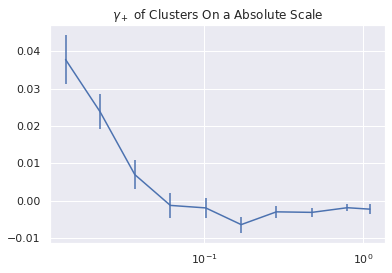

Aggregated xi:
[-33.488  -48.9081 -23.1678   7.2168  20.2759 121.1531 103.6691 201.4477
 239.1993 144.0824]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -3819.2089  -7839.9524 -11024.8126 -15438.8568 -23386.5754 -33131.1365
 -42908.3266 -46922.1634 -28198.0036   6321.1457]
------------------------------------------------------------------------------
Aggregated npairs:
[   886.   2058.   3334.   5531.  10262.  18775.  34216.  63519. 124335.
  62380.]
------------------------------------------------------------------------------
Mean xi:
[-0.0378 -0.0238 -0.0069  0.0013  0.002   0.0065  0.003   0.0032  0.0019
  0.0023]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3106 -3.8095 -3.3068 -2.7913 -2.2789 -1.7646 -1.254  -0.7387 -0.2268
  0.1013]
------------------------------------------------------------------------------


In [30]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

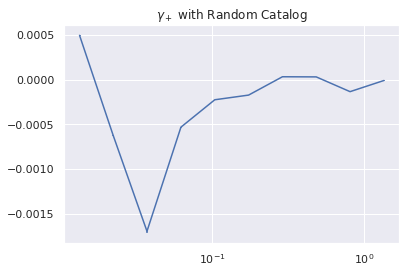

[ 4.9332e-04 -6.2438e-04 -1.6901e-03 -5.3002e-04 -2.2471e-04 -1.7261e-04
  3.1751e-05  3.0225e-05 -1.3427e-04 -1.0015e-05]
[-4.4173e-06  5.5909e-06  1.5134e-05  4.7459e-06  2.0121e-06  1.5456e-06
 -2.8431e-07 -2.7065e-07  1.2023e-06  8.9676e-08]


In [31]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

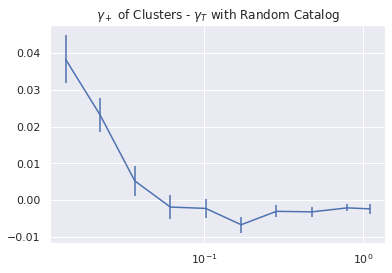

In [32]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

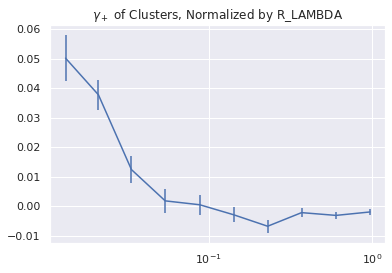

Aggregated xi:
[-24.5997 -47.2423 -29.2774  -6.6669  -2.8932  31.1431 127.3677  71.5982
 183.432  211.2635]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -2113.6193  -4817.357   -7985.9088 -10717.2628 -14297.4888 -21043.737
 -27594.9425 -32670.1534 -30004.093   -3501.2228]
------------------------------------------------------------------------------
Aggregated npairs:
[   490.   1251.   2358.   3681.   5894.  10787.  18761.  32884.  58910.
 108206.]
------------------------------------------------------------------------------
Mean xi:
[-0.0502 -0.0378 -0.0124 -0.0018 -0.0005  0.0029  0.0068  0.0022  0.0031
  0.002 ]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3135 -3.8508 -3.3867 -2.9115 -2.4258 -1.9508 -1.4709 -0.9935 -0.5093
 -0.0324]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [33]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)